# DeepSeek 1.3B PLOTS

DeepSeek VL 1.3B chat : https://huggingface.co/deepseek-ai/deepseek-vl-1.3b-chat and https://github.com/deepseek-ai/DeepSeek-VL/blob/main/README.md

LLM Disclaimer: Debugging was done with the help of ChatGPT: https://chatgpt.com/ 

In [106]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix

In [107]:
temp_rate=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# FUNCTIONS

In [111]:
def get_metrics_deep_seek(deep_seek_df, target_col='diabetic_retinopathy', 
                           fold_numbers=list(range(10)), is_multiclass=False):
    deep_seek_df = deep_seek_df.copy()

    fold_cols = [f'output_binary_fold_{i}' for i in fold_numbers]

    deep_seek_df.loc[:, 'deepseek_answers_all_folds'] = deep_seek_df[fold_cols].max(axis=1, skipna=True)

    #print("Number of NaN in combined predictions:", deep_seek_df['deepseek_answers_all_folds'].isna().sum())

    valid_rows_all =  deep_seek_df[ deep_seek_df['deepseek_answers_all_folds'].notna()]
    y_true_all = valid_rows_all[target_col]
    y_pred_all = valid_rows_all['deepseek_answers_all_folds']

    acc_all = accuracy_score(y_true_all, y_pred_all)
    f1_all = f1_score(y_true_all, y_pred_all, average='macro' if is_multiclass else 'binary')
    #print(f"Combined folds: Accuracy = {acc_all:.4f}, F1 = {f1_all:.4f}\n")

    metrics = []
    for i in fold_numbers:
        col = f'output_binary_fold_{i}'
        col_for_cov = f'output{i}'
        col_for_cov_rows = deep_seek_df[deep_seek_df[col_for_cov].notna()]
        valid_rows = deep_seek_df[deep_seek_df[col].notna()]
        y_true = valid_rows[target_col]
        y_pred = valid_rows[col]

        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='macro' if is_multiclass else 'binary')
        precision = precision_score(y_true, y_pred, average='macro' if is_multiclass else 'binary')
        recall = recall_score(y_true, y_pred, average='macro' if is_multiclass else 'binary')
        acc_bal = balanced_accuracy_score(y_true, y_pred)

        metrics.append({
            'fold': i,
            'accuracy': acc,
            'f1': f1,
            'precision': precision,
            'recall': recall,
            'acc_bal': acc_bal,
            'number_of_answers_per_fold': len(valid_rows),
            'coverage_per_fold': len(valid_rows)/len(col_for_cov_rows)
        })

        #print(f"Fold {i}: Accuracy = {acc:.4f}, F1 = {f1:.4f}")

    metrics_df = pd.DataFrame(metrics)

    return metrics_df

In [112]:
def do_one_df_metrics_DS (filenames_construction, temp_rate=temp_rate, target_col='diabetic_retinopathy'):
    all_metrics = []
    for i in temp_rate:
        performance = pd.read_csv(filenames_construction.format(tau=i))
        fold_metrics = get_metrics_deep_seek(performance)
        fold_metrics["tau"] = i
        all_metrics.append(fold_metrics)
    return pd.concat(all_metrics, ignore_index=True)

In [115]:
def plot_metrics(metrics_df, metric, temp_rate=temp_rate):
    n_taus = len(temp_rate)
    n_cols = 3
    n_rows = int(np.ceil(n_taus / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols,5*n_rows), sharey=True)
    axes = axes.flatten()

    for ax, t in zip(axes, temp_rate):
        tau_df = metrics_df[metrics_df["tau"] == t]
        sns.barplot(x='fold', y=metric, data=tau_df, ax=ax, color='skyblue', errorbar=None)
        mean_val = tau_df[metric].mean()
        std_val = tau_df[metric].std()
        ax.axhline(mean_val, color='red', linestyle='--', label=f"Mean = {mean_val:.2f}")
        ax.fill_between(
            x=range(len(tau_df)),
            y1=mean_val-std_val,
            y2=mean_val+std_val,
            color='red',
            alpha=0.2,
            label="±1 SD"
        )
        for i, val in enumerate(tau_df[metric]):
            ax.text(i, val/2, f"{val:.2f}", ha='center', va='center', fontsize=10)
        ax.set_xticks(range(len(tau_df['fold'])))
        ax.set_xticklabels(tau_df['fold'], rotation=45, ha='right')
        ax.set_title(f"Tau = {t}, Metric: {metric}", fontsize=14)
        ax.set_xlabel("Fold", fontsize=12)
        ax.set_ylabel(metric)
        ax.set_ylim(0,1)
        ax.legend(loc='lower right', fontsize=10)

    for j in range(len(temp_rate), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

### SHORT 01 no System Instructions

In [114]:
all_metrics_deep_seek_short_taus = do_one_df_metrics_DS(filenames_construction="DS3B_shot0_short_prompt_version_si0_BD_mini_01/BD_mini_DS_tau_{tau}_01.csv")
all_metrics_deep_seek_short_taus.head()

/.pyenv/versions/miniconda3-latest/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/.pyenv/versions/miniconda3-latest/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/.pyenv/versions/miniconda3-latest/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

fold  accuracy   f1  precision  recall  acc_bal  \
0     0  0.694323  0.0        0.0     0.0      0.5   
1     1  0.694323  0.0        0.0     0.0      0.5   
2     2  0.692982  0.0        0.0     0.0      0.5   
3     3  0.692982  0.0        0.0     0.0      0.5   
4     4  0.692982  0.0        0.0     0.0      0.5   

   number_of_answers_per_fold  coverage_per_fold  tau  
0                         229                1.0  0.1  
1                         229                1.0  0.1  
2                         228                1.0  0.1  
3                         228                1.0  0.1  
4                         228                1.0  0.1

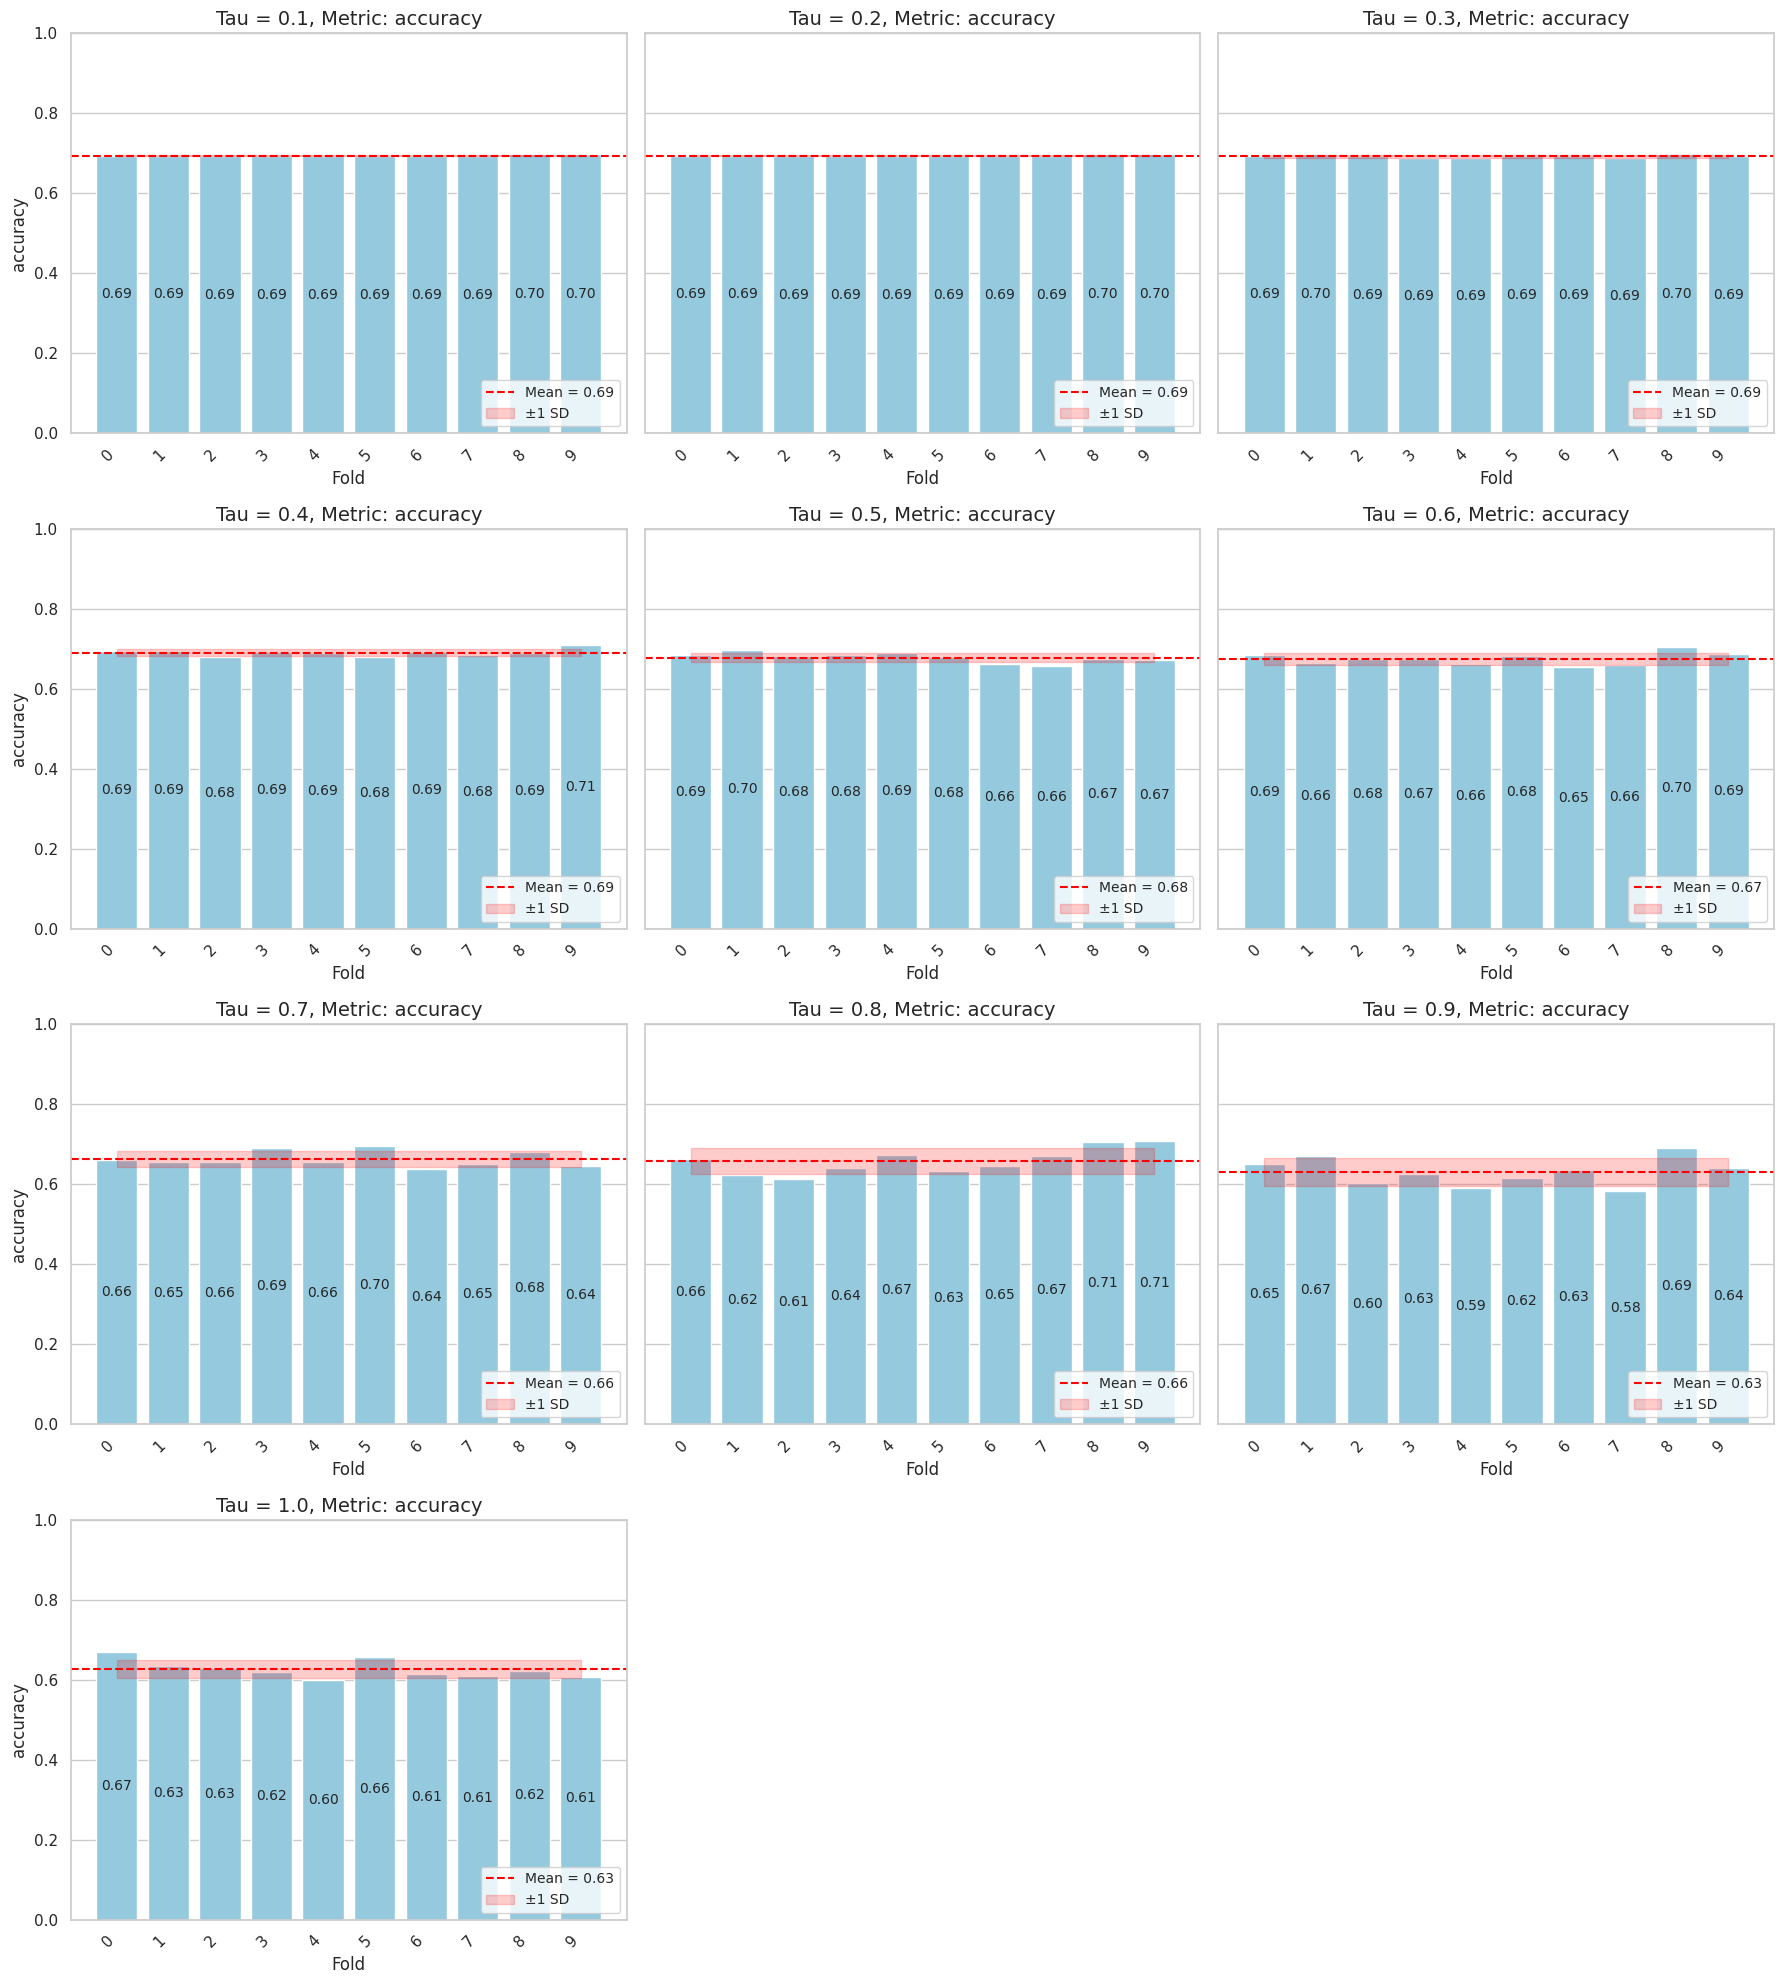

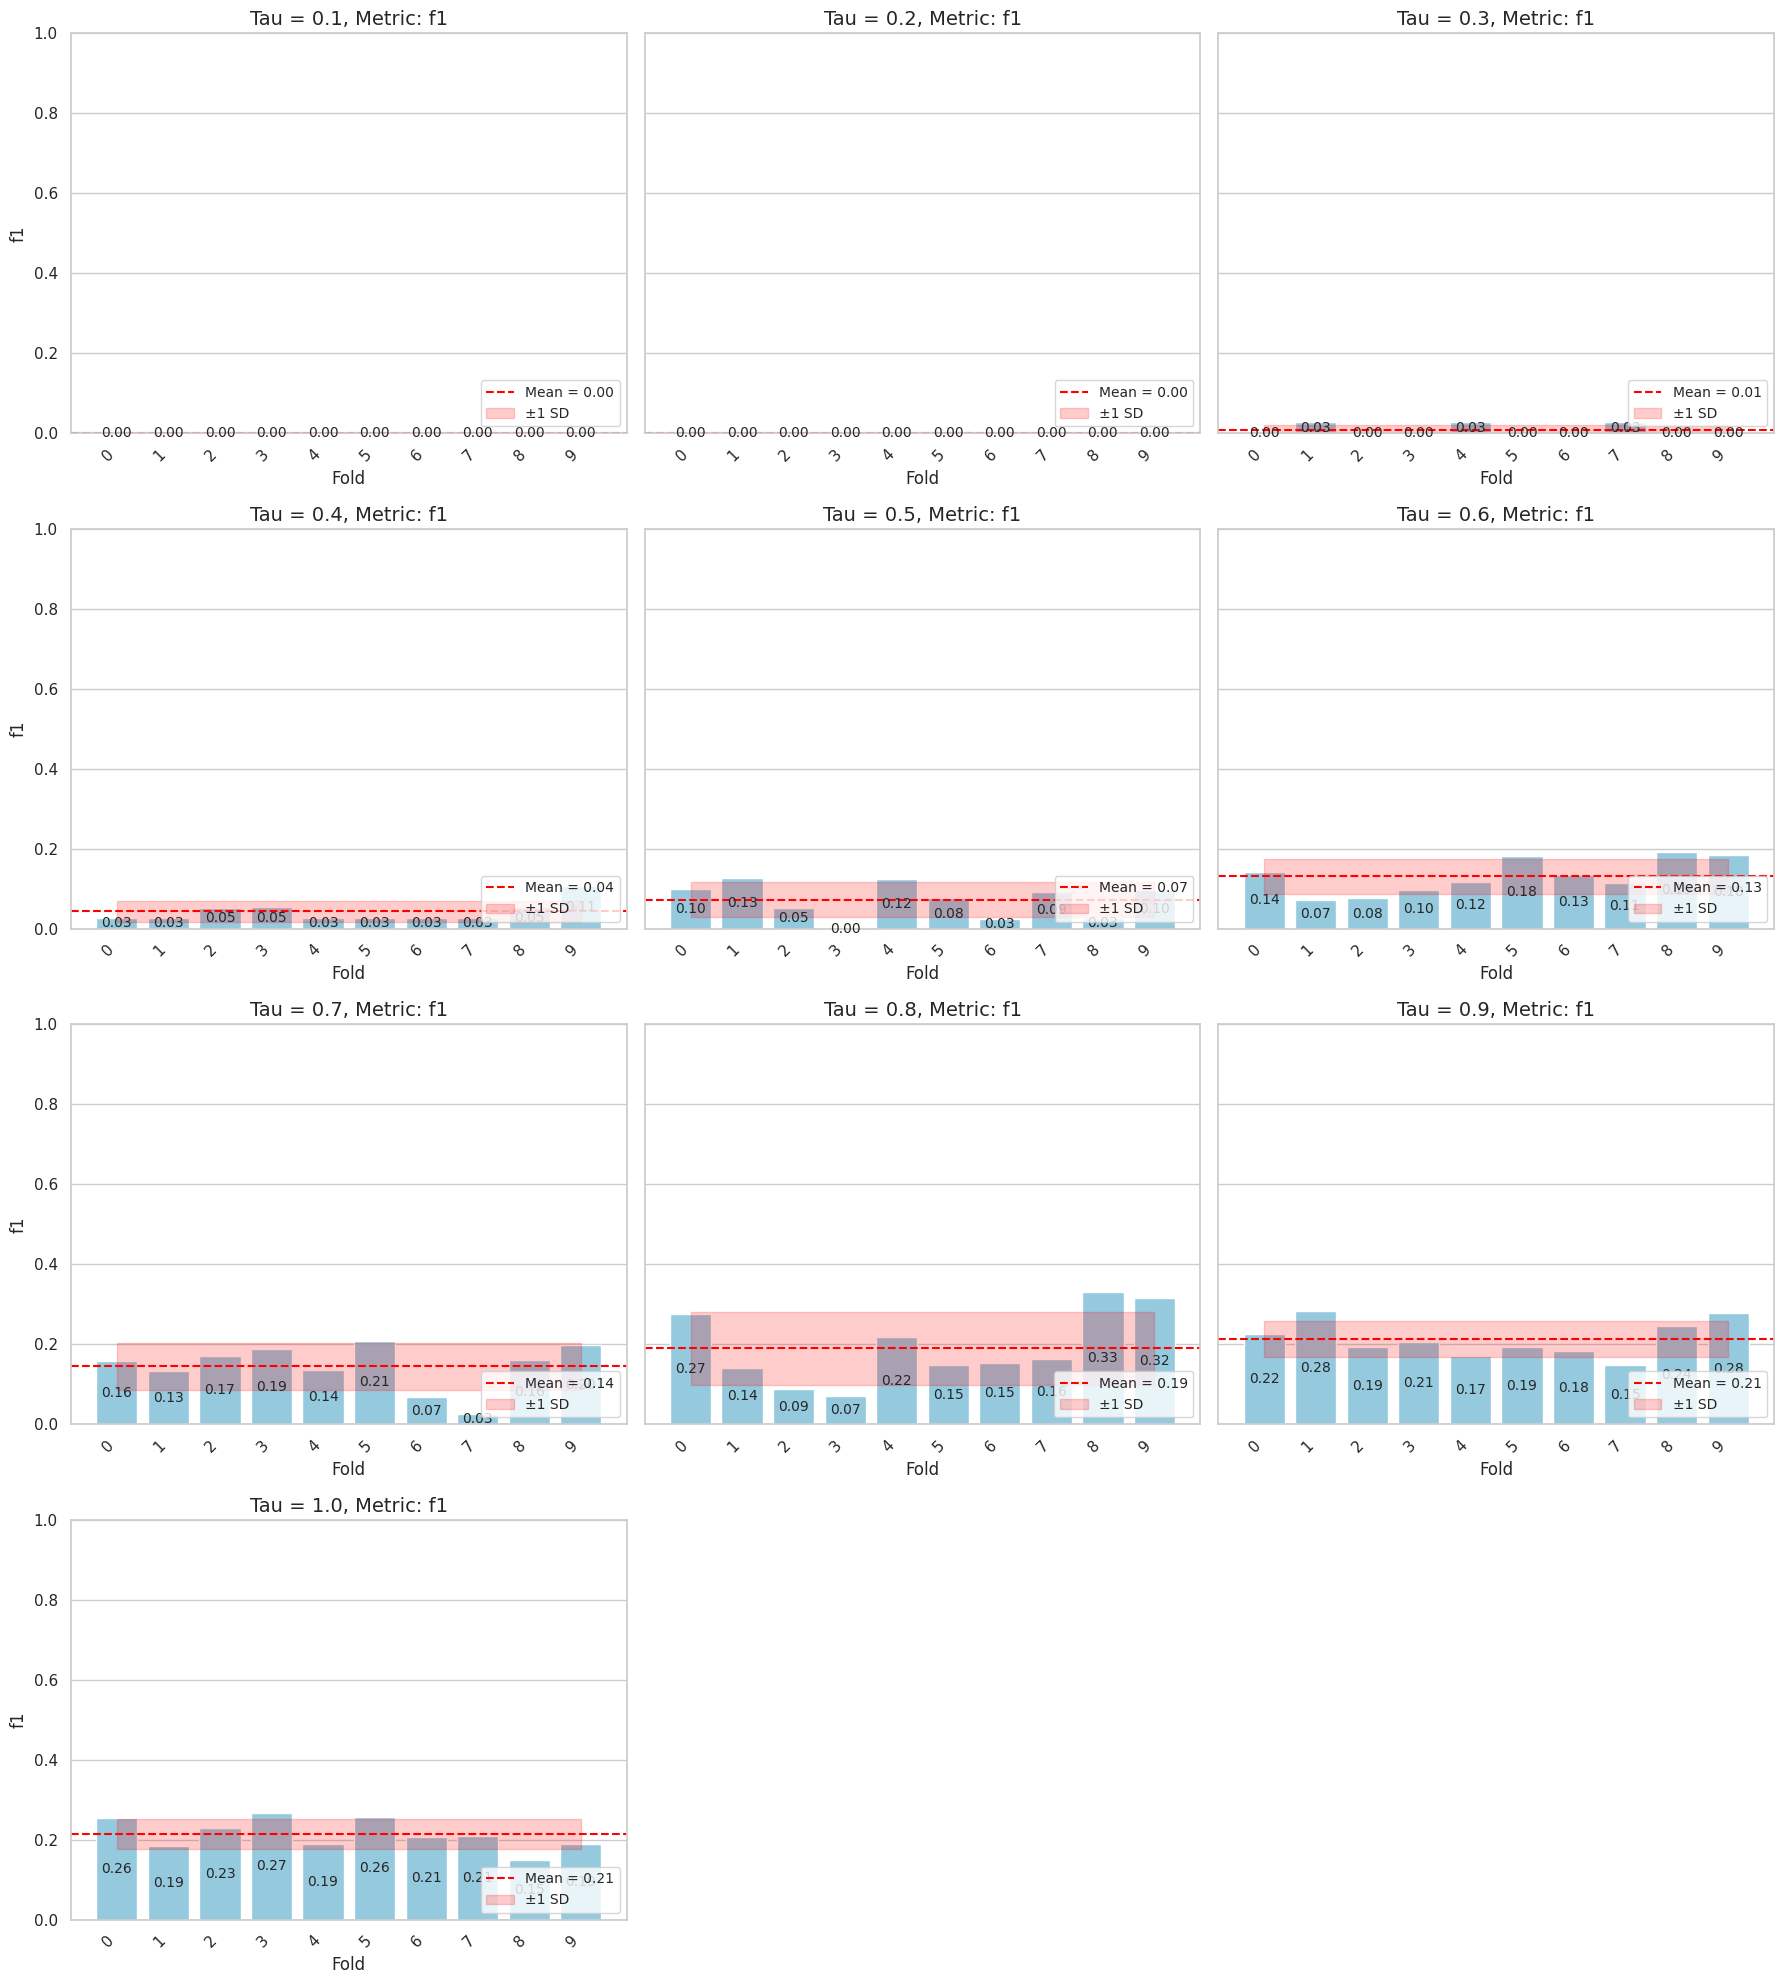

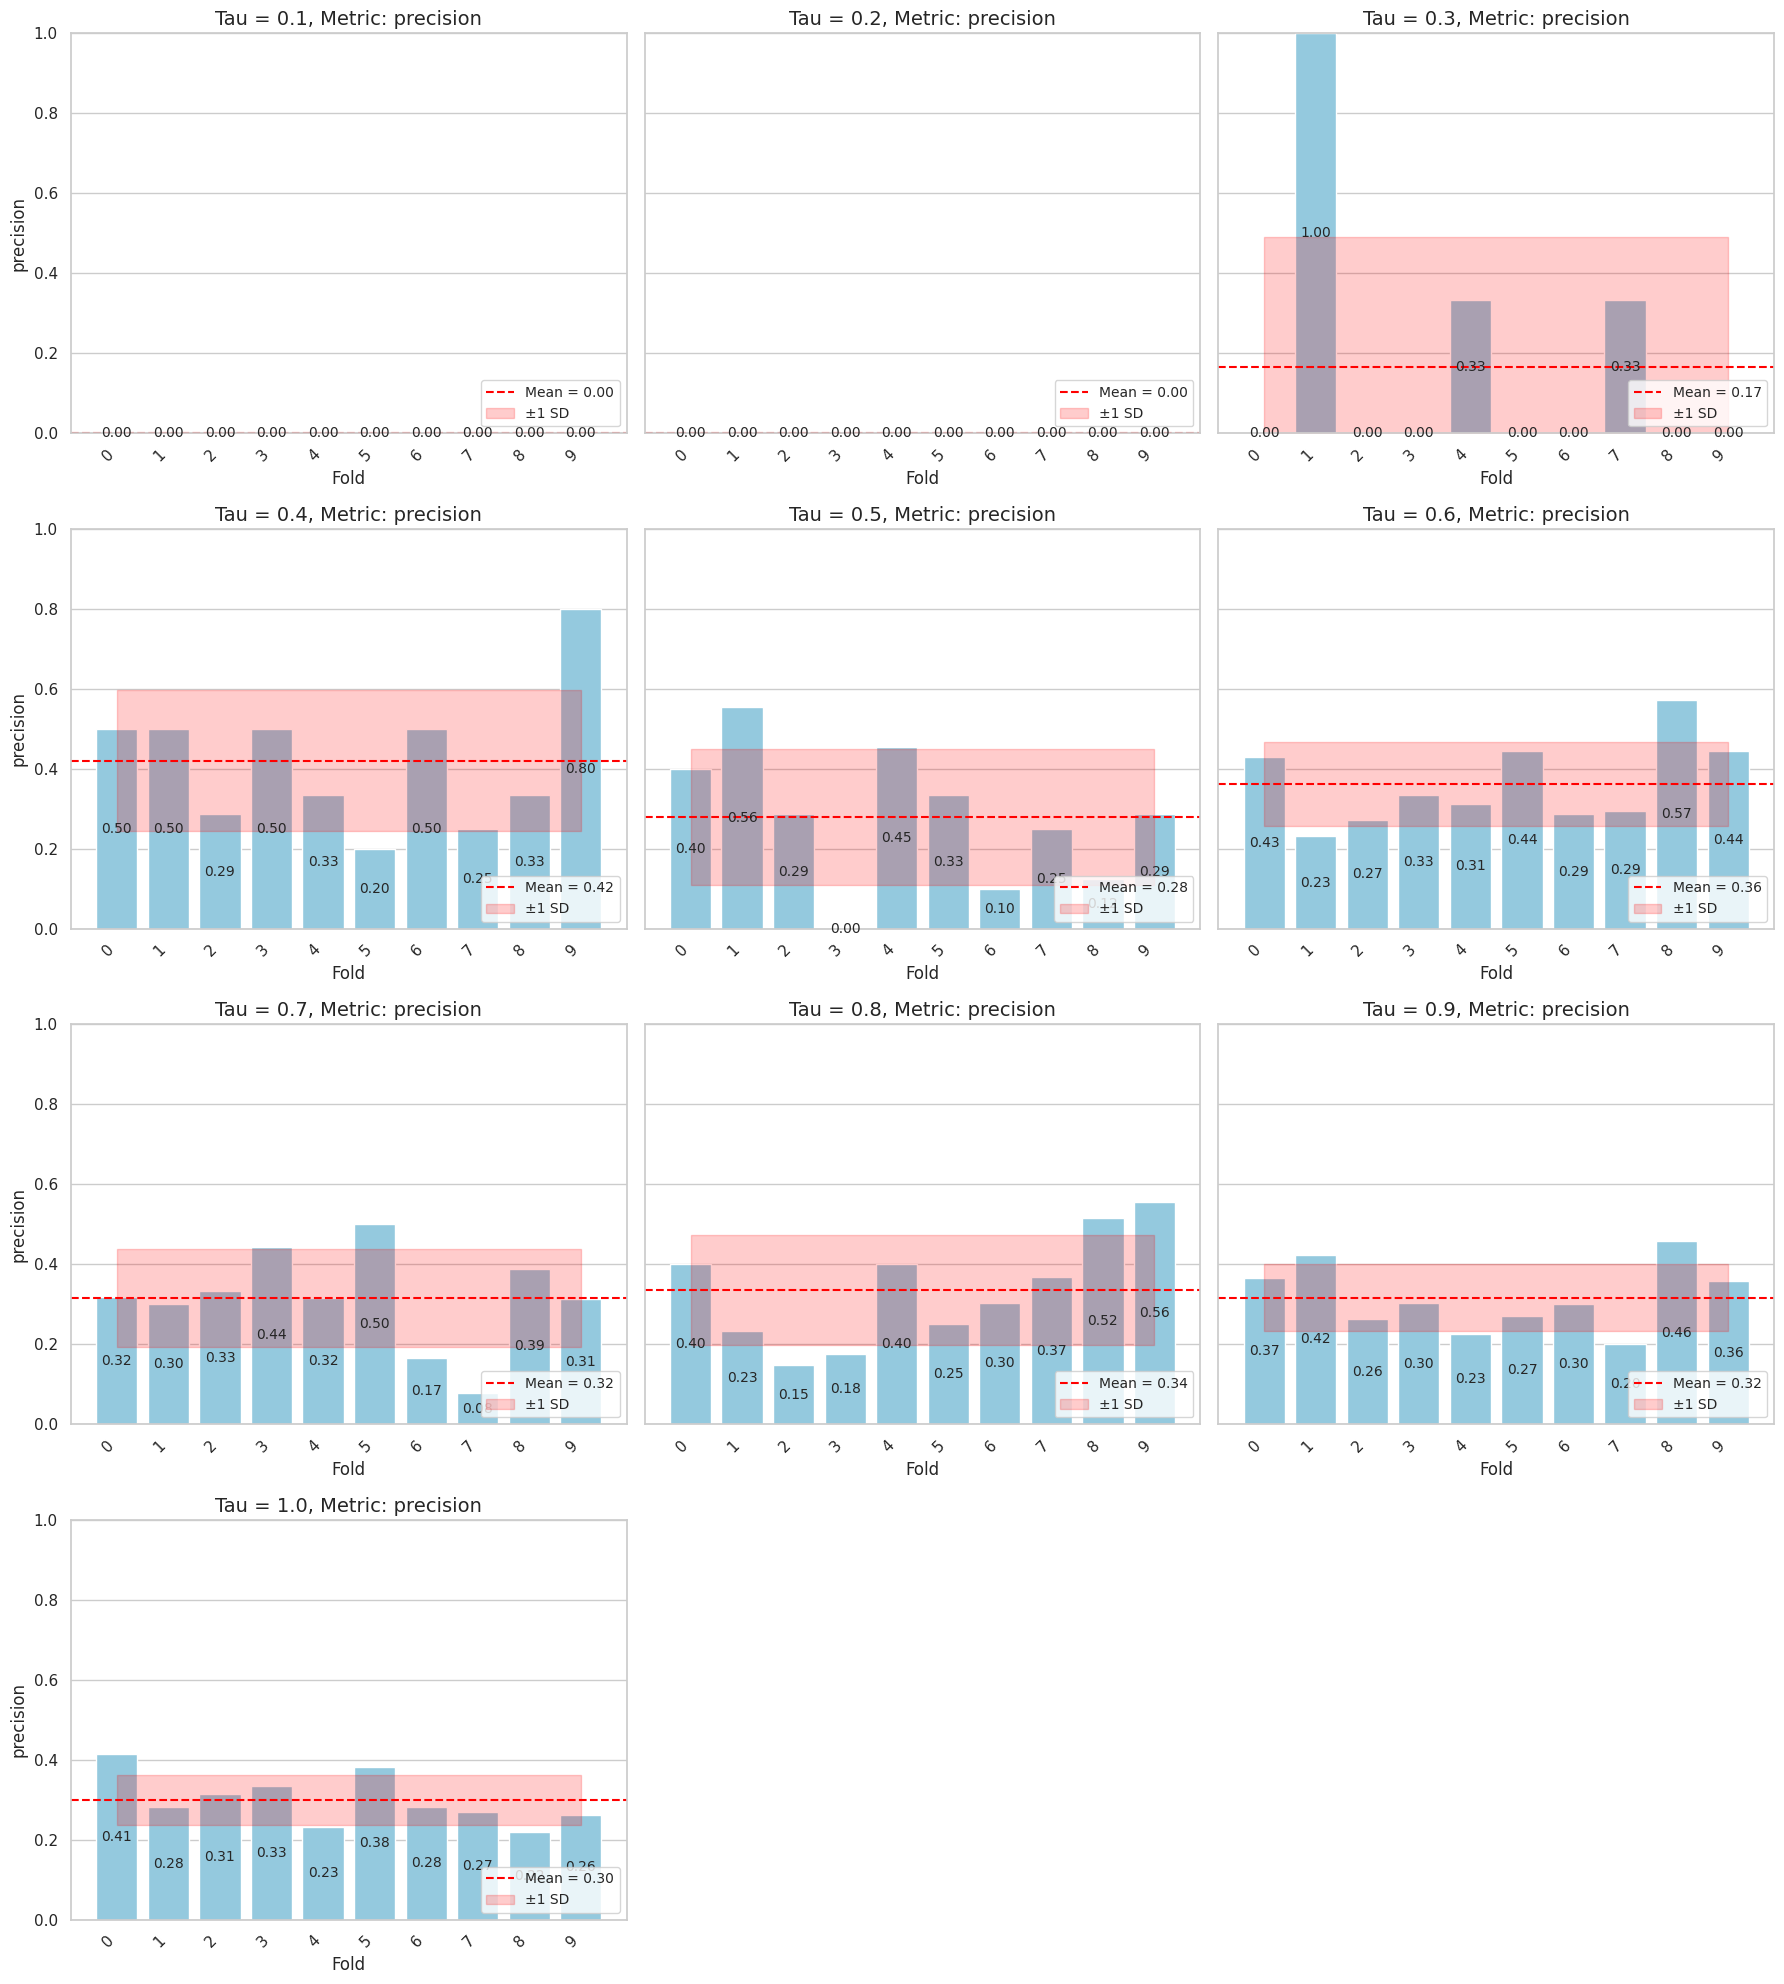

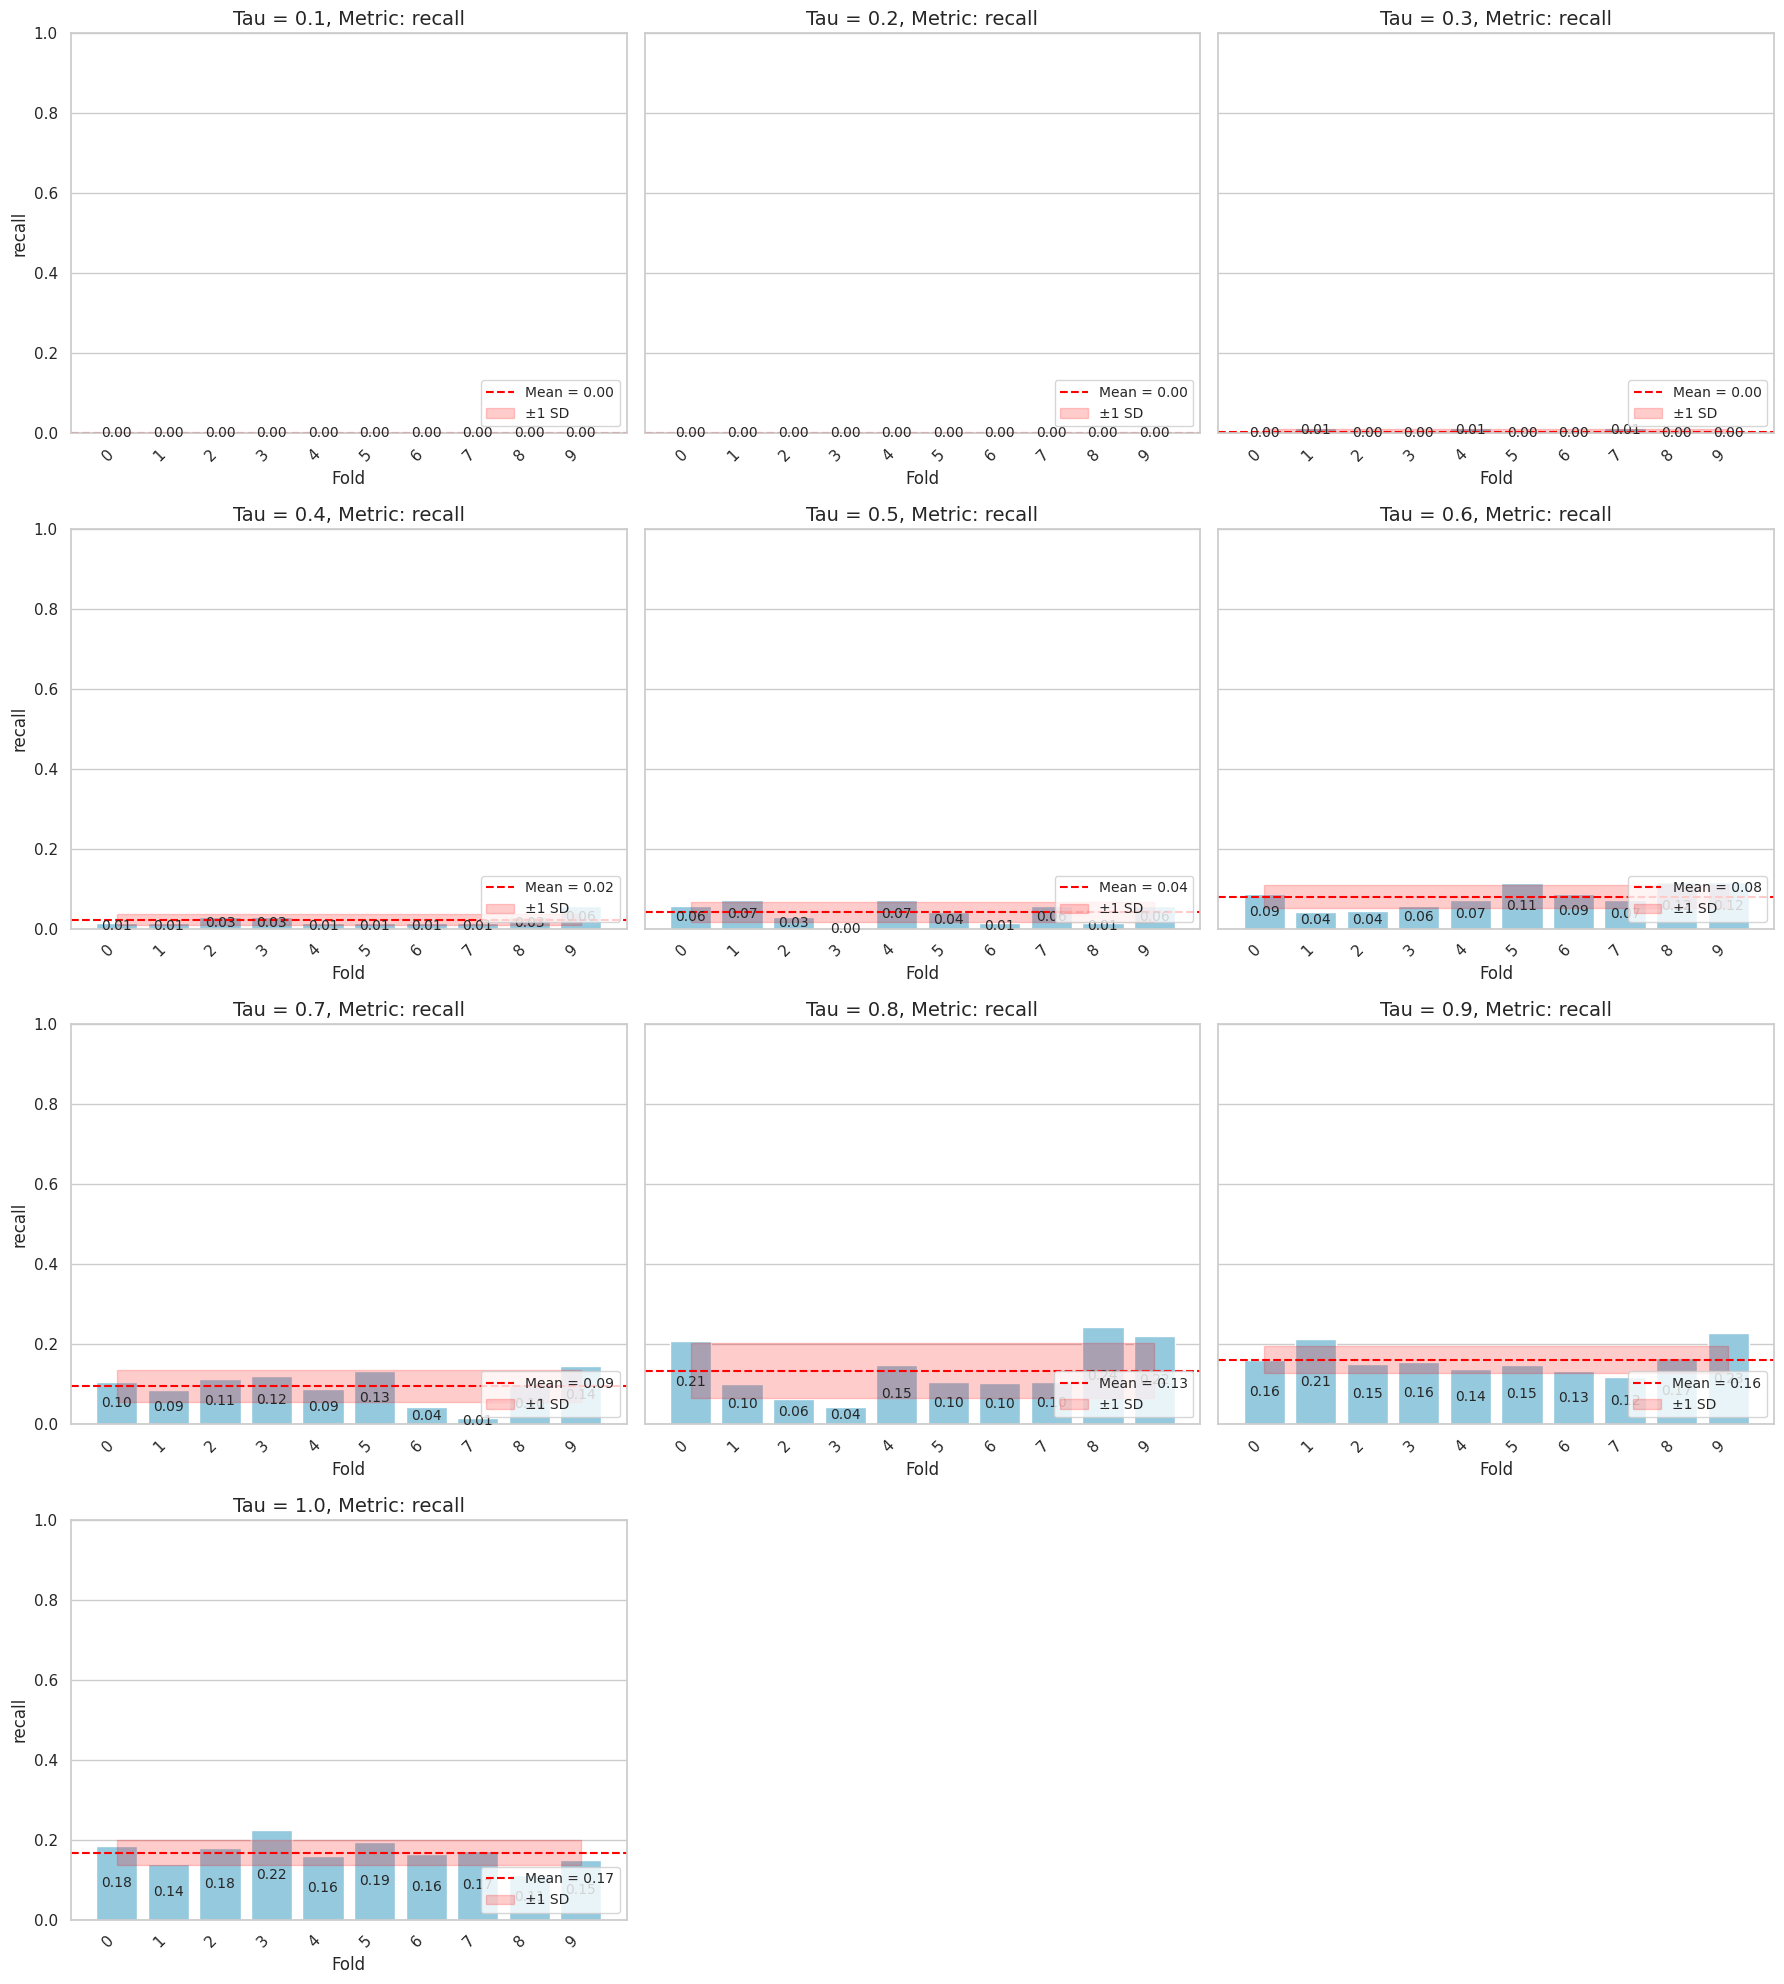

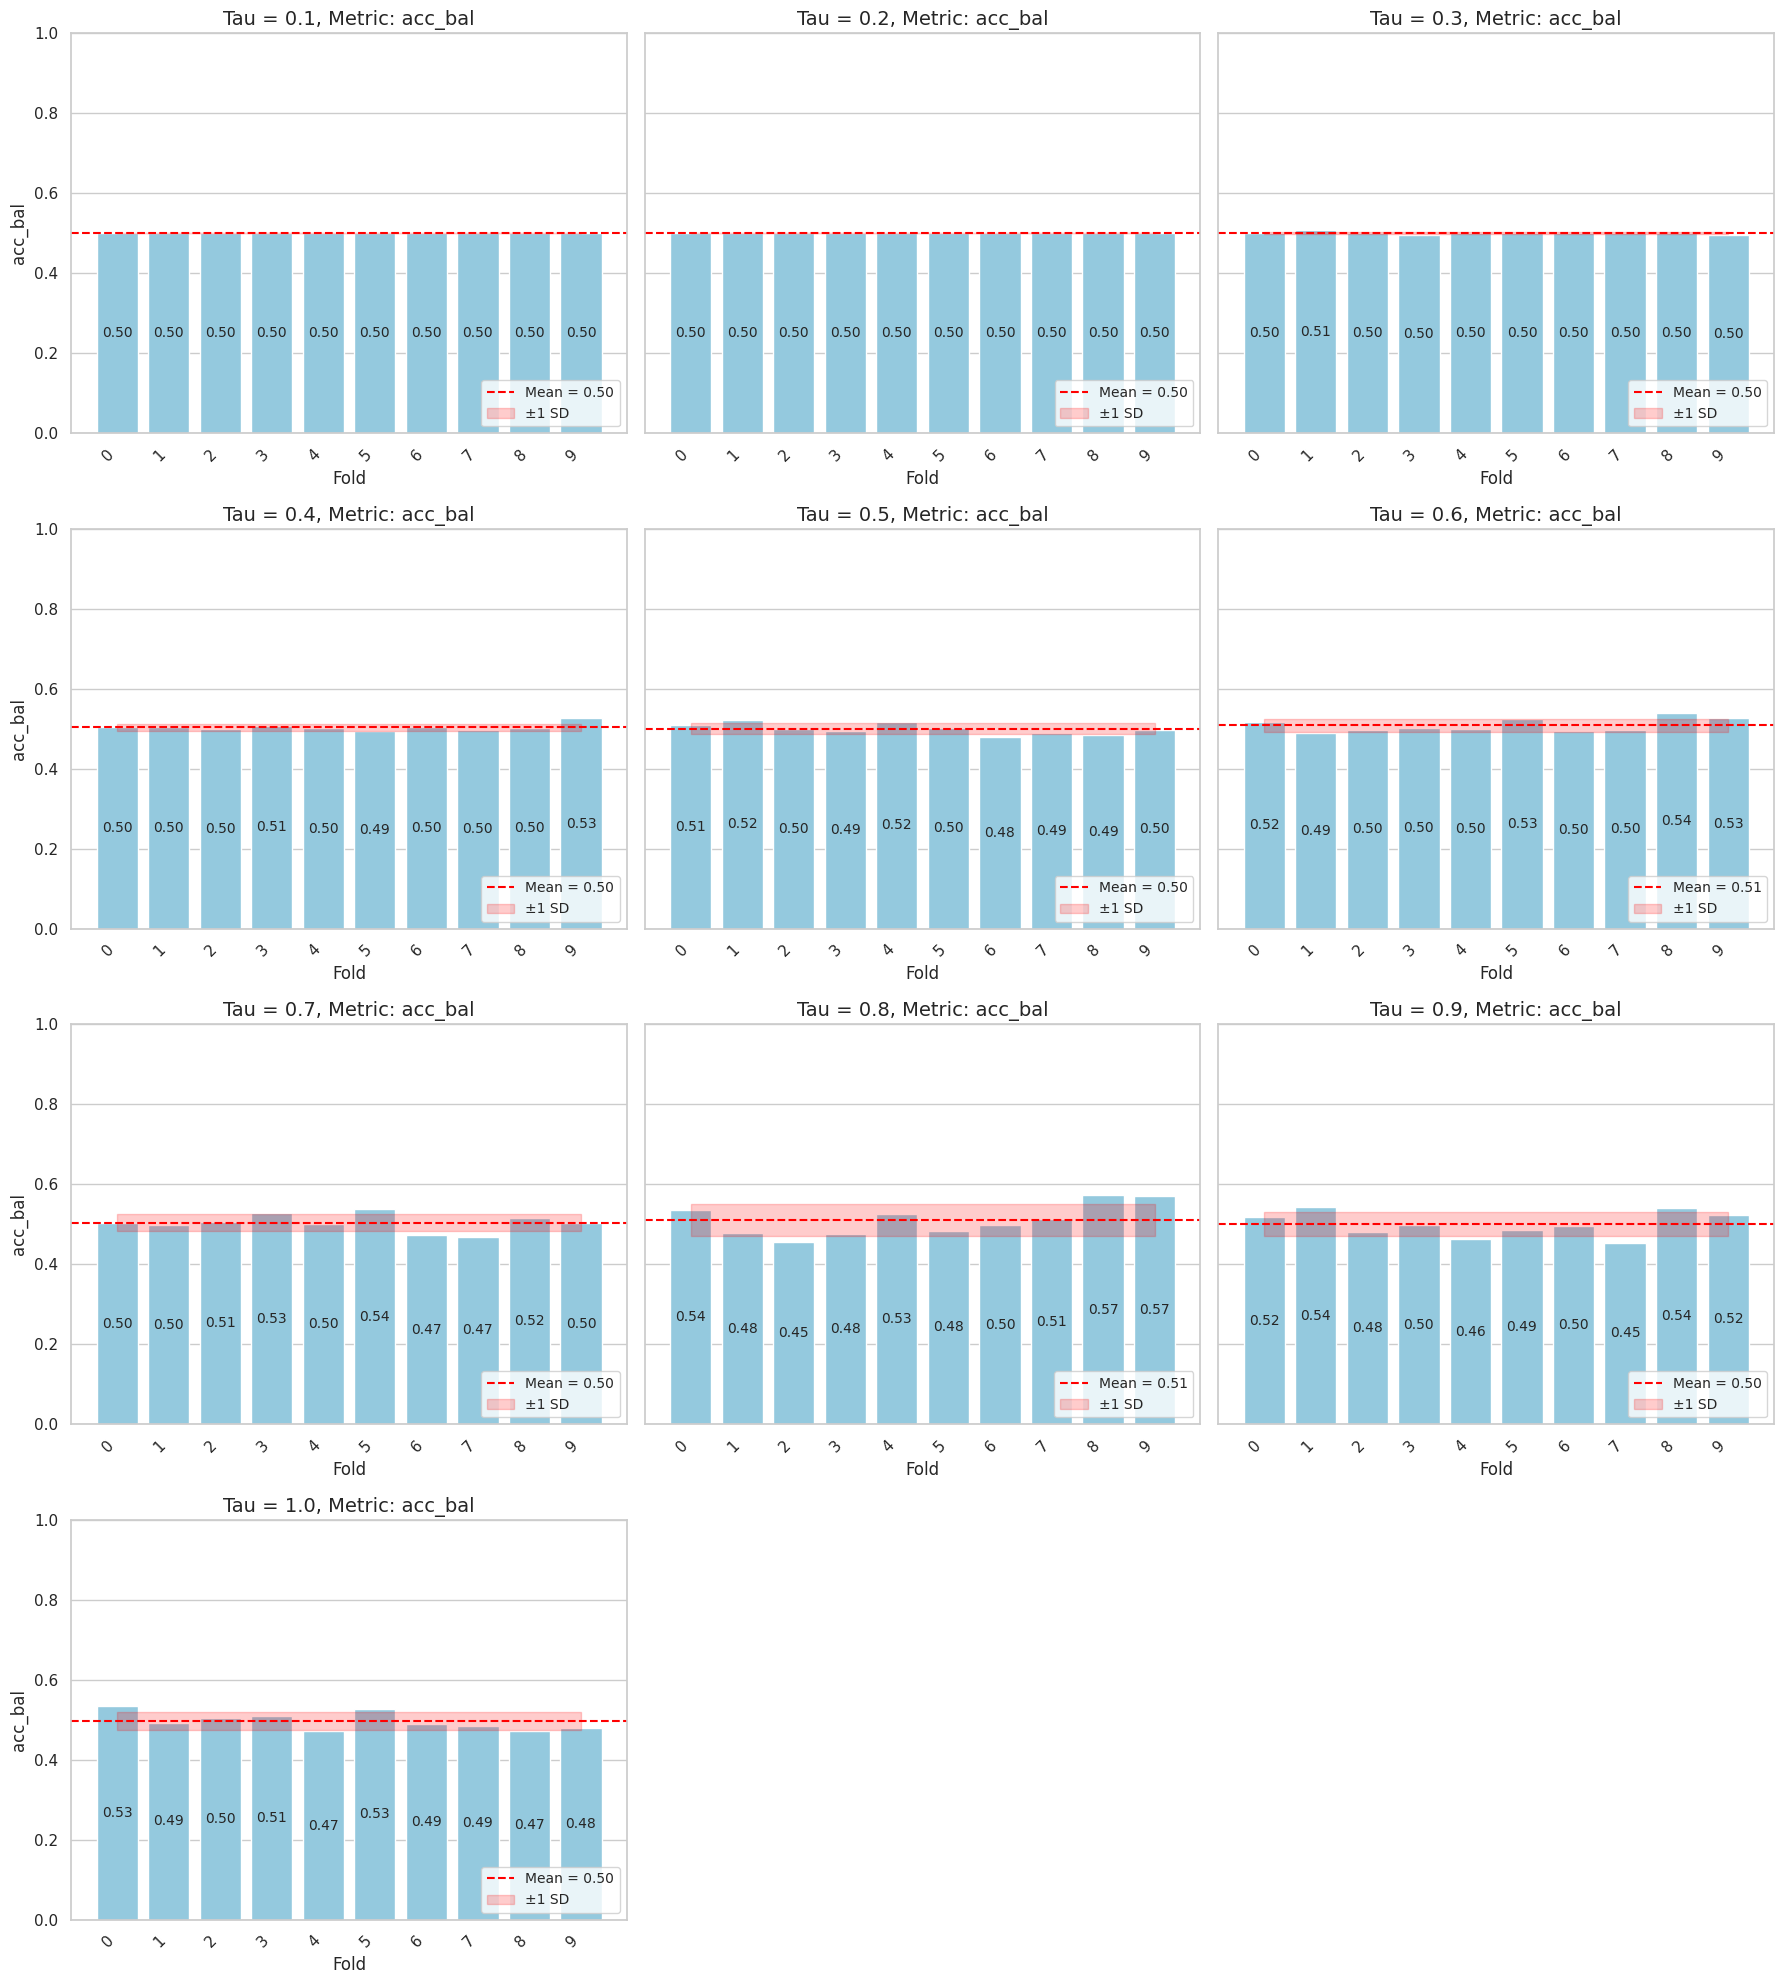

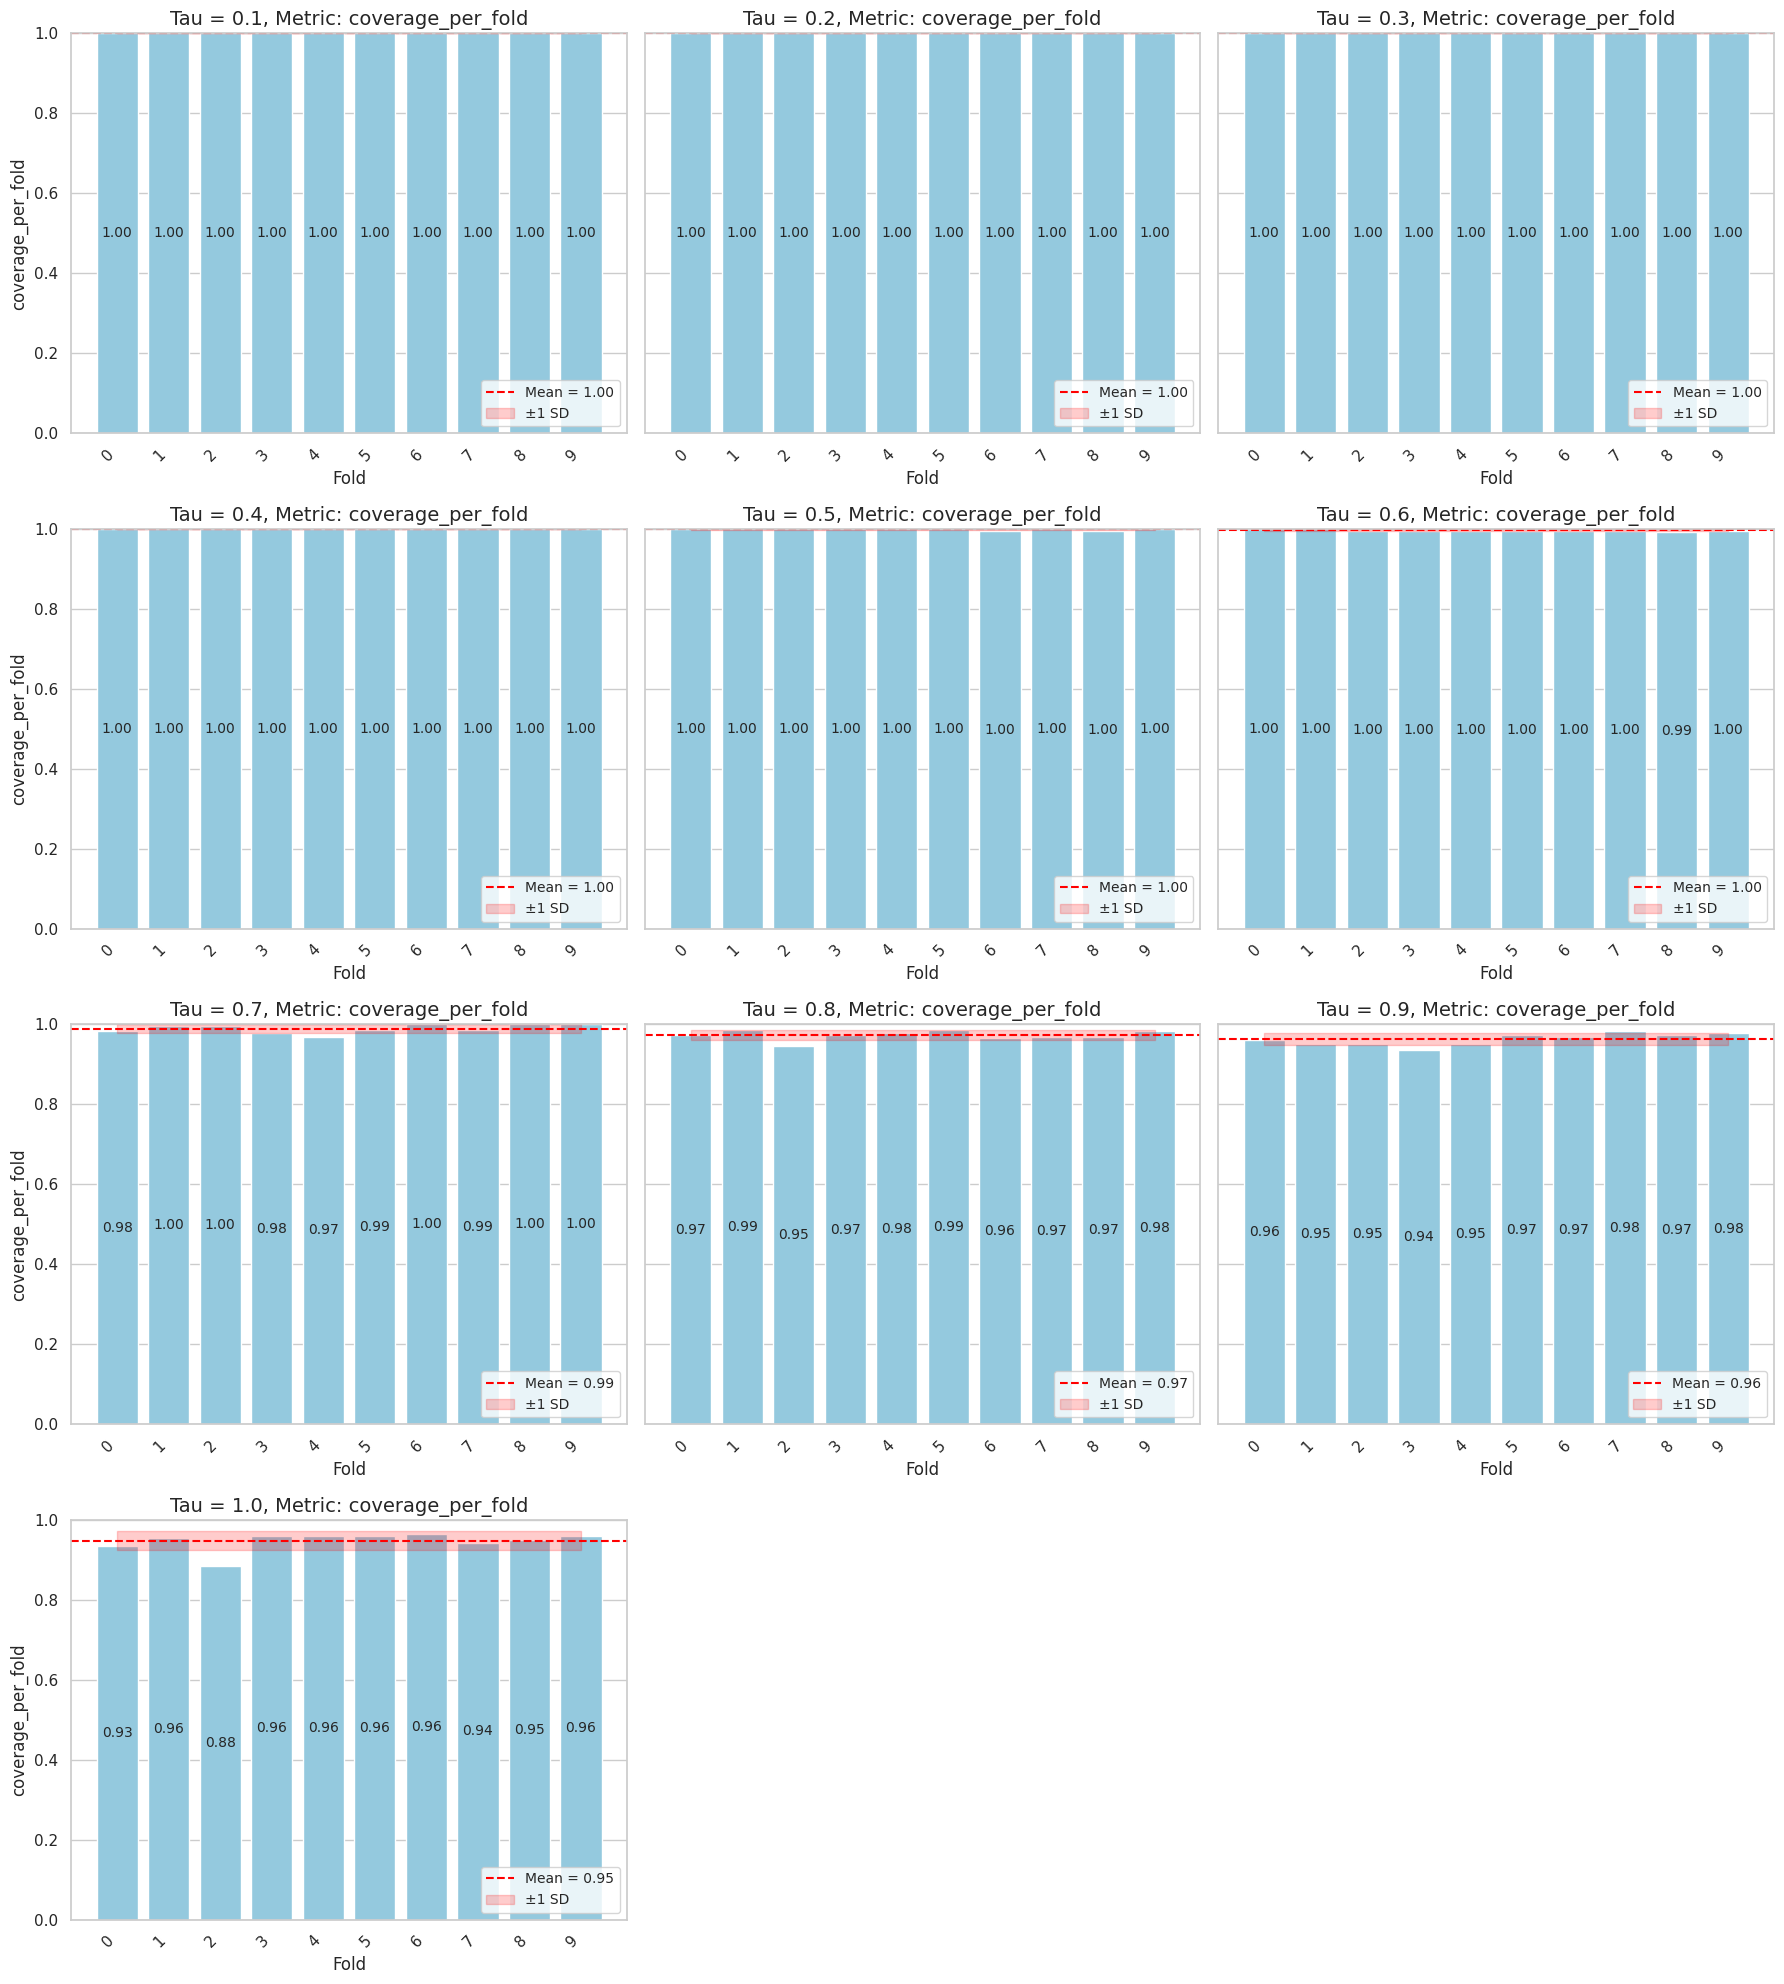

In [116]:
mets = [ 'accuracy', 'f1','precision','recall','acc_bal', 'coverage_per_fold']
for i in mets:
    plot_metrics(all_metrics_deep_seek_short_taus, i)

### LONG 01 no System Instructions

In [83]:
all_metrics_deep_seek_taus_long = do_one_df_metrics_DS(filenames_construction="DS3B_shot0_long_version_si0_BD_mini_01/BD_mini_DS_tau_{tau}_shot_0_01_long_version.csv")
all_metrics_deep_seek_taus_long.head()

/.pyenv/versions/miniconda3-latest/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/.pyenv/versions/miniconda3-latest/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/.pyenv/versions/miniconda3-latest/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

fold  accuracy   f1  precision  recall  acc_bal  \
0     0  0.694323  0.0        0.0     0.0      0.5   
1     1  0.694323  0.0        0.0     0.0      0.5   
2     2  0.692982  0.0        0.0     0.0      0.5   
3     3  0.692982  0.0        0.0     0.0      0.5   
4     4  0.692982  0.0        0.0     0.0      0.5   

   number_of_answers_per_fold  coverage_per_fold  tau  
0                         229                1.0  0.1  
1                         229                1.0  0.1  
2                         228                1.0  0.1  
3                         228                1.0  0.1  
4                         228                1.0  0.1

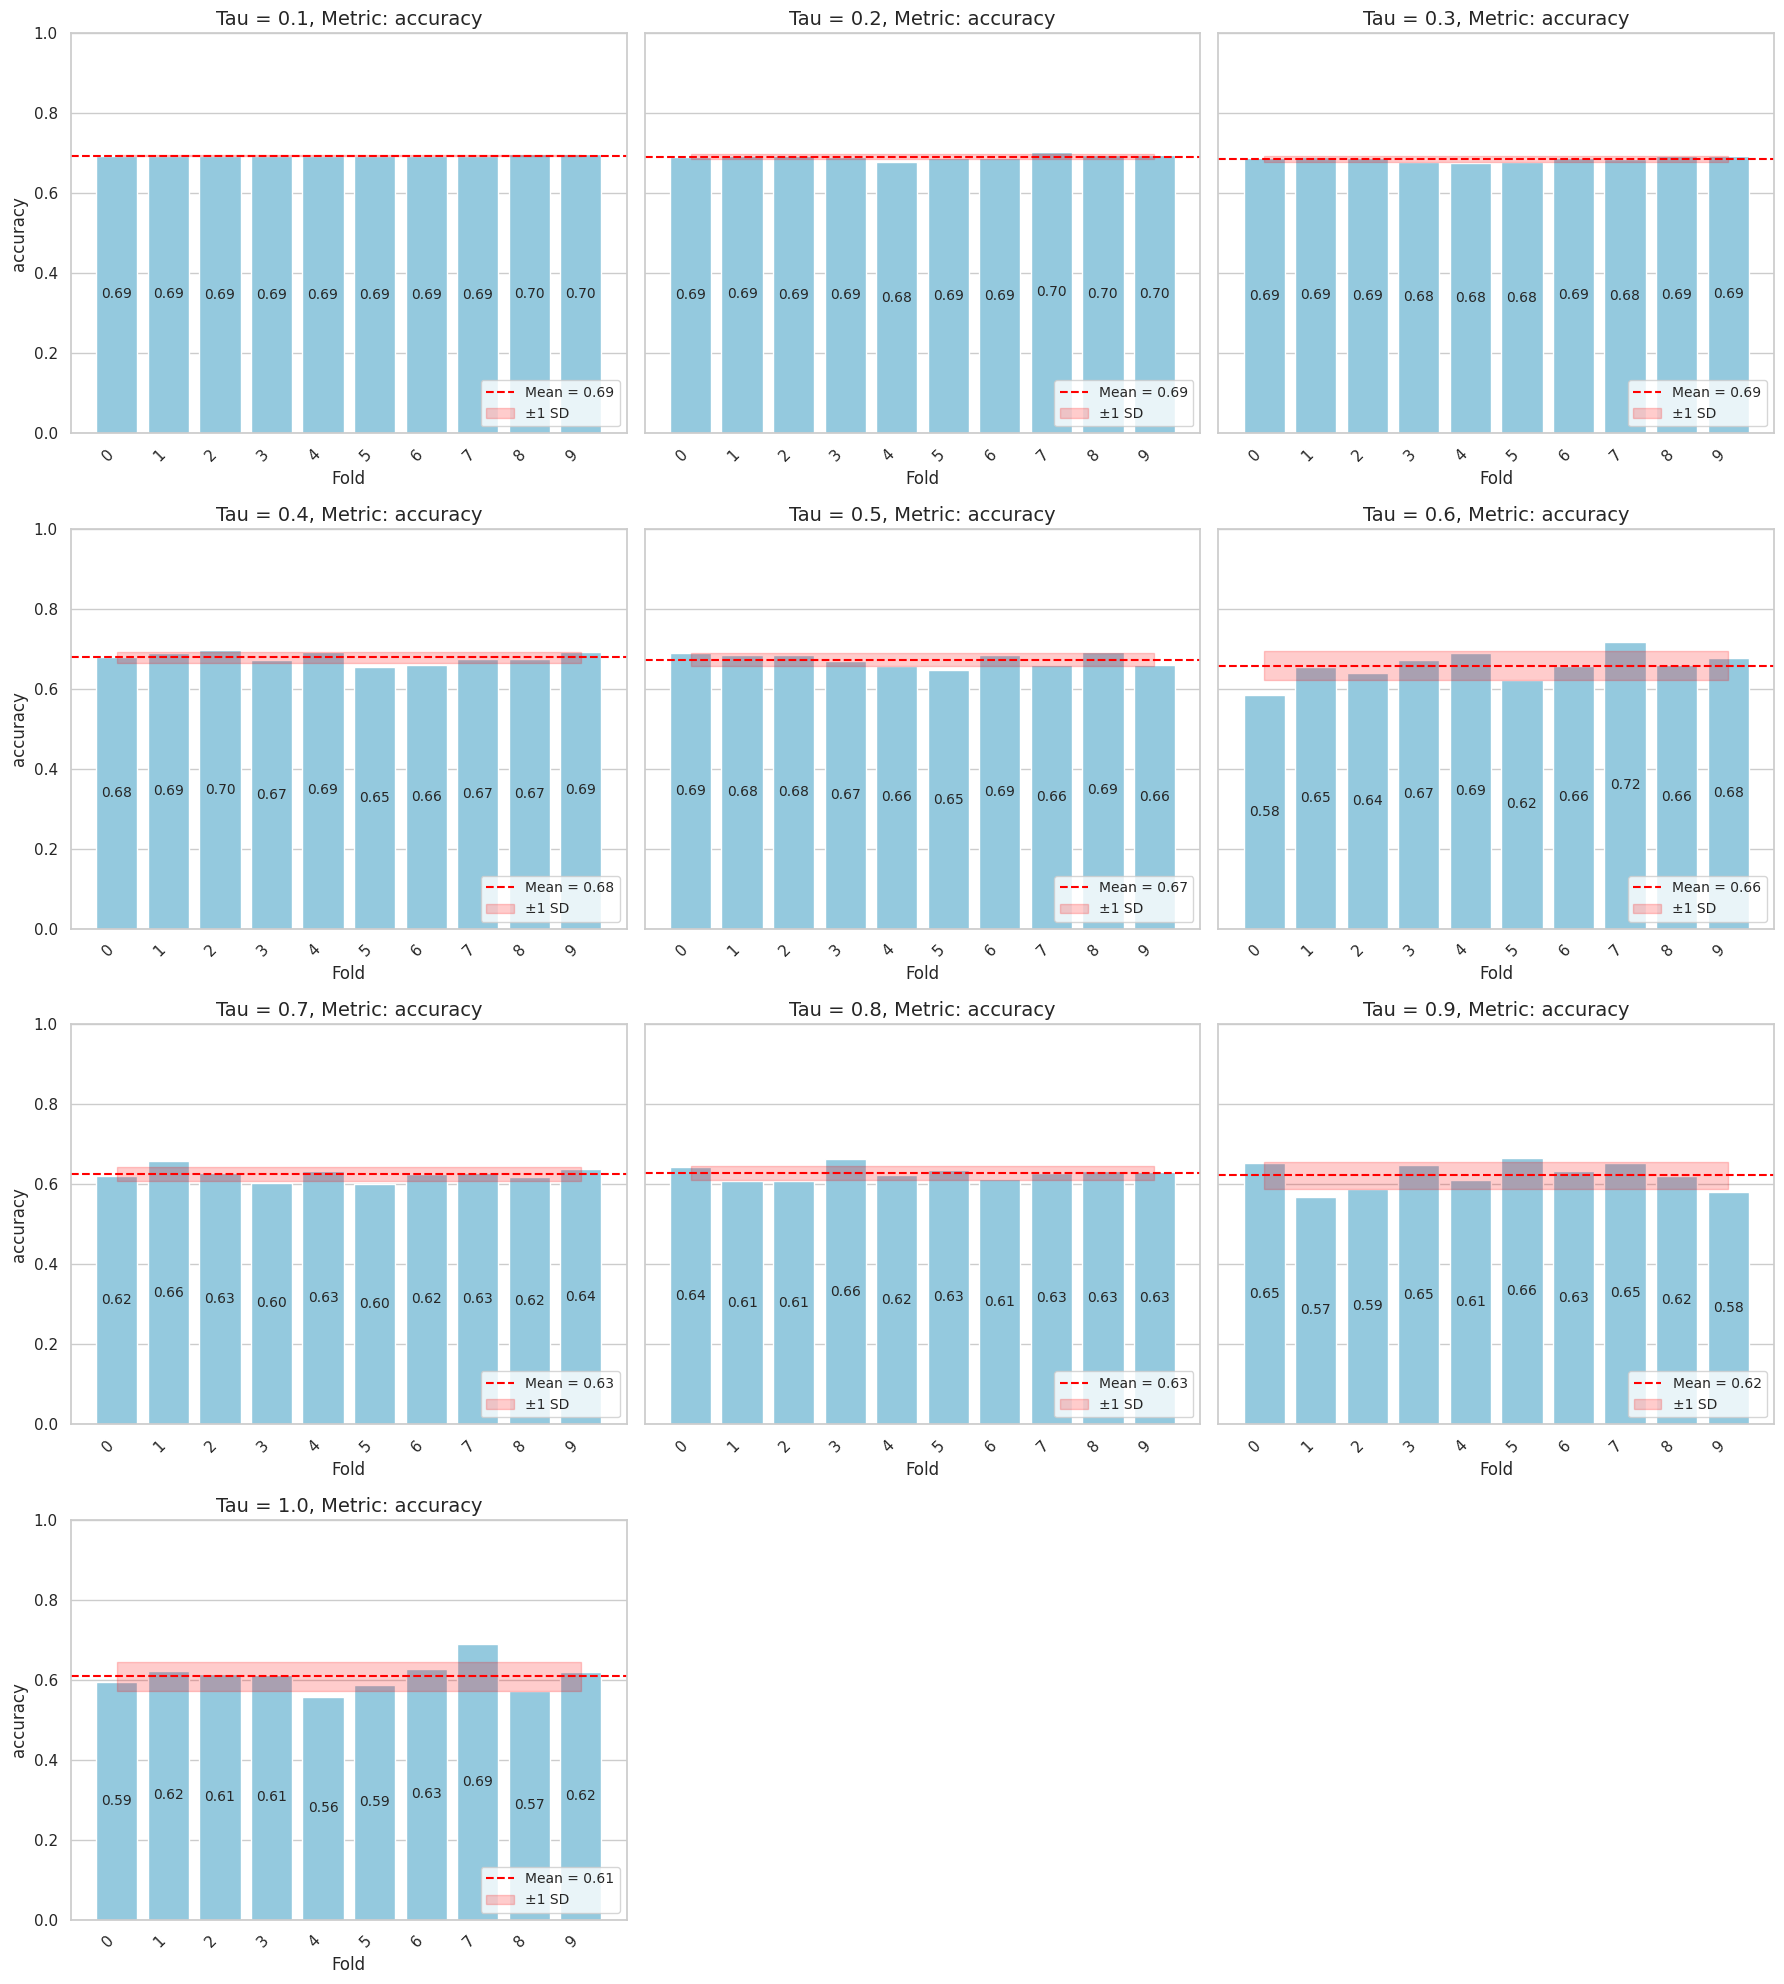

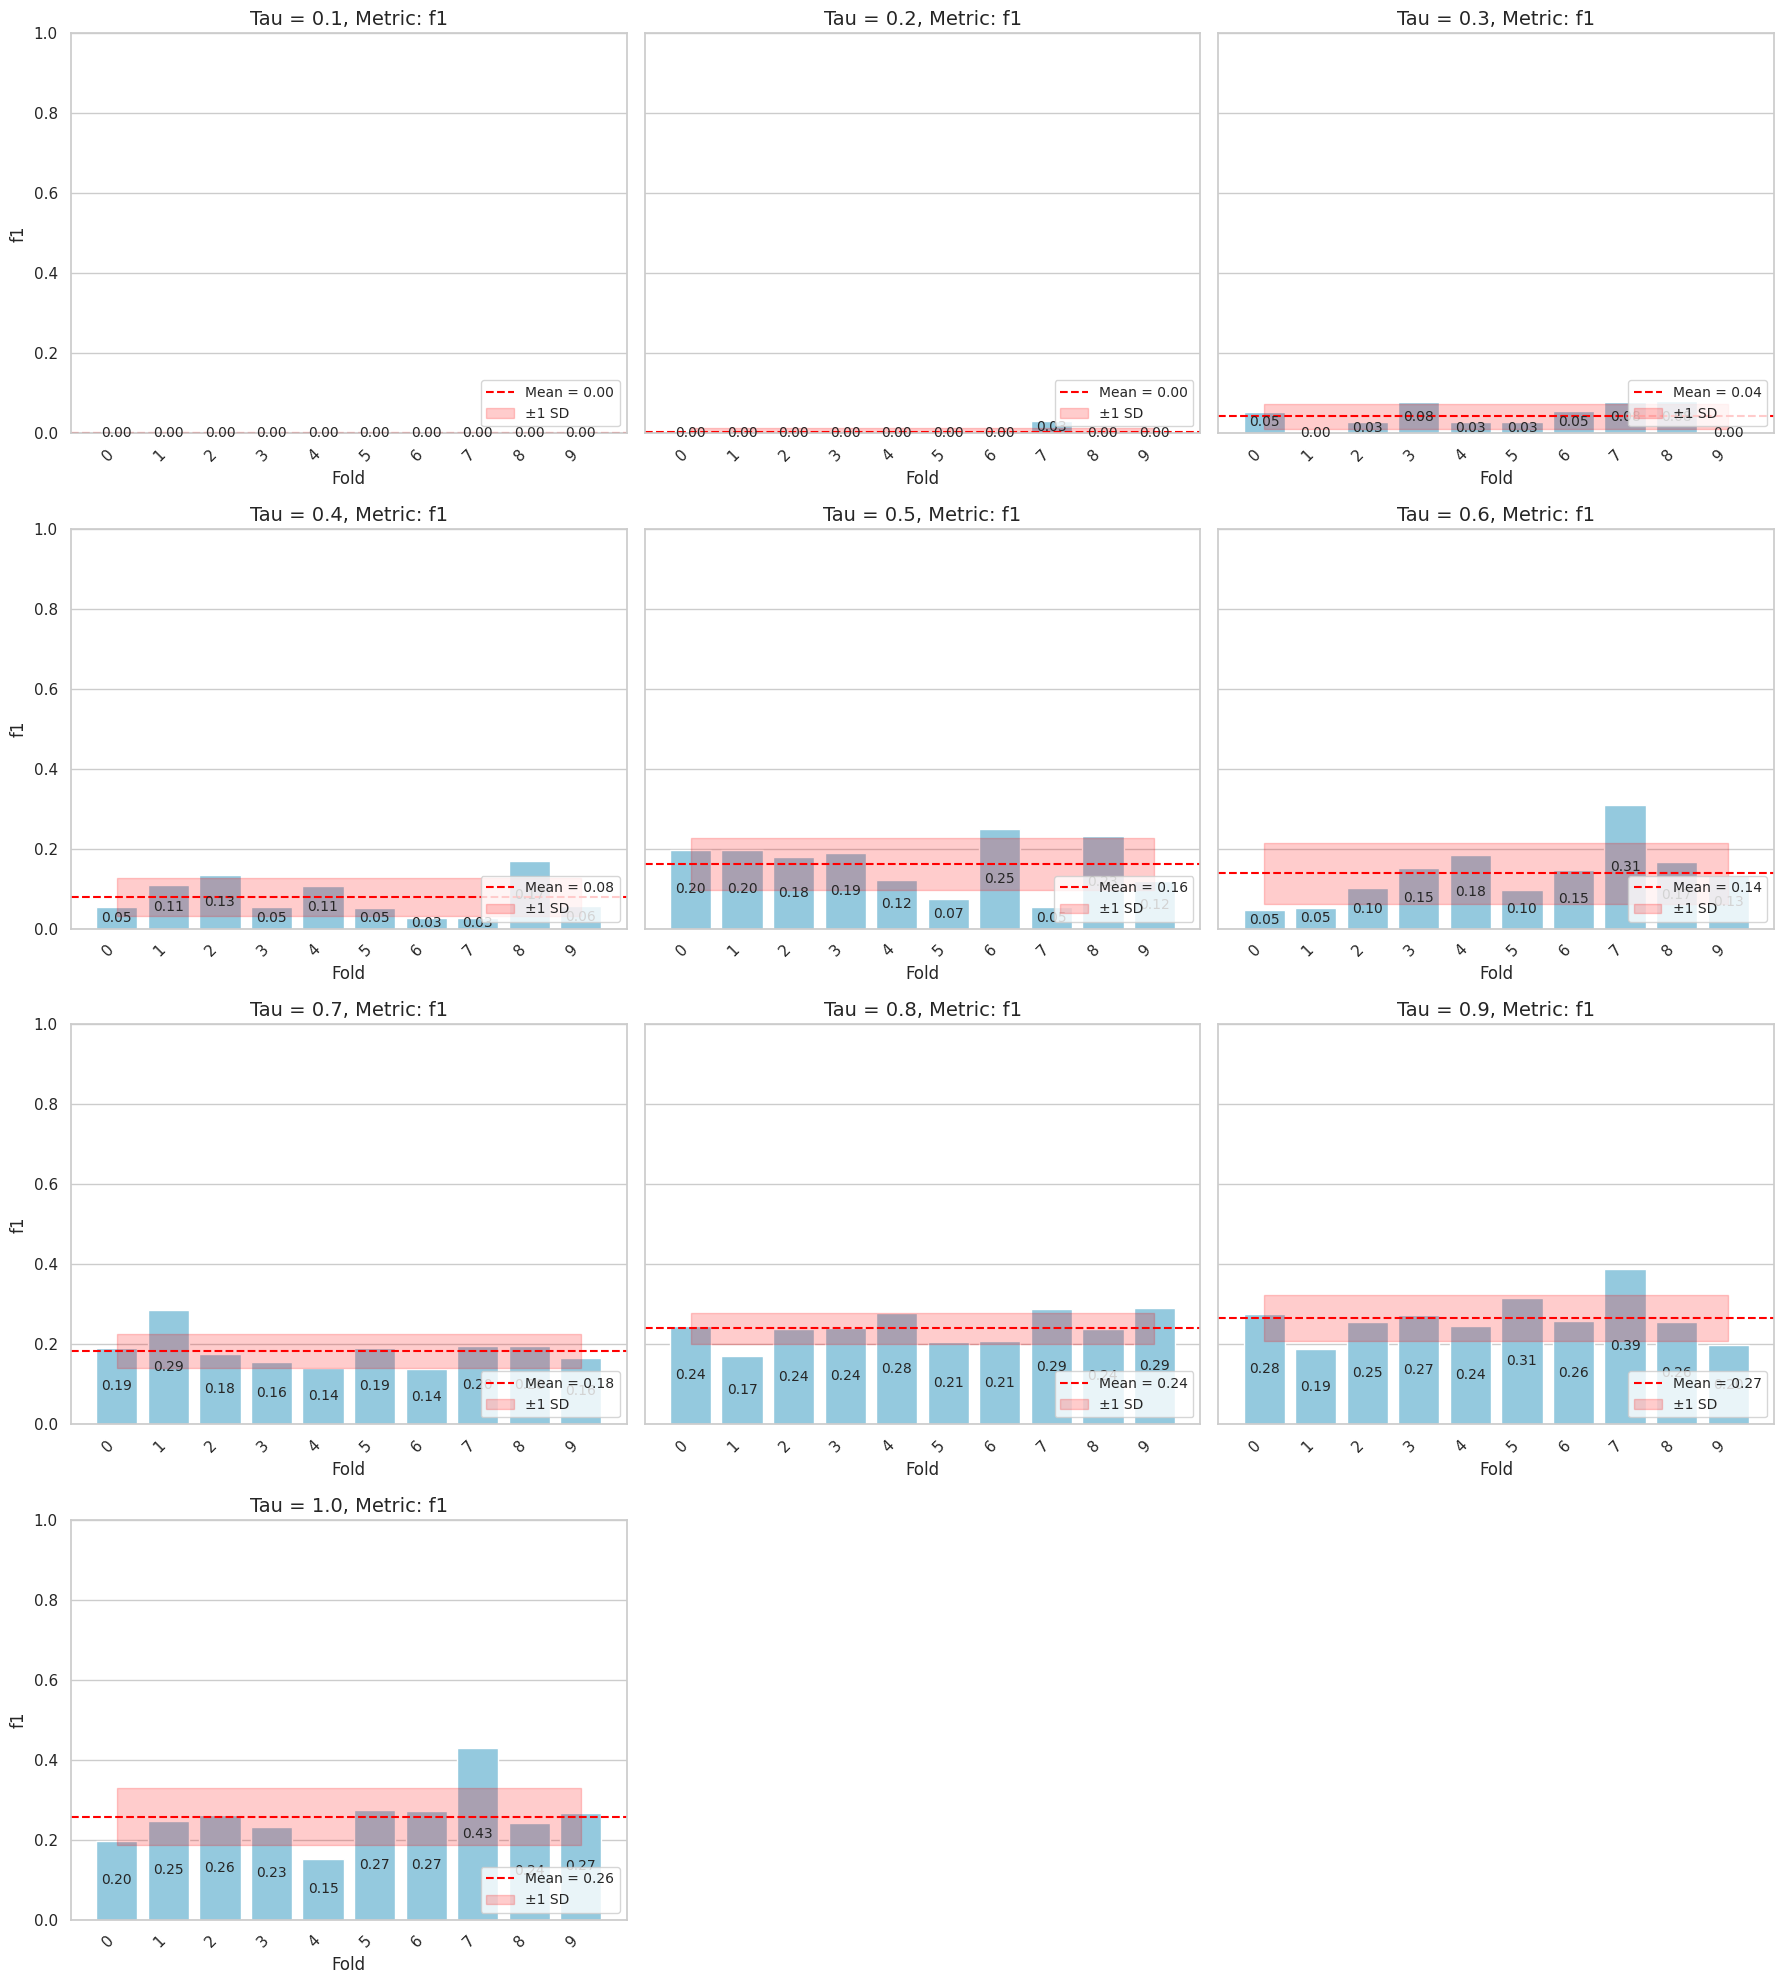

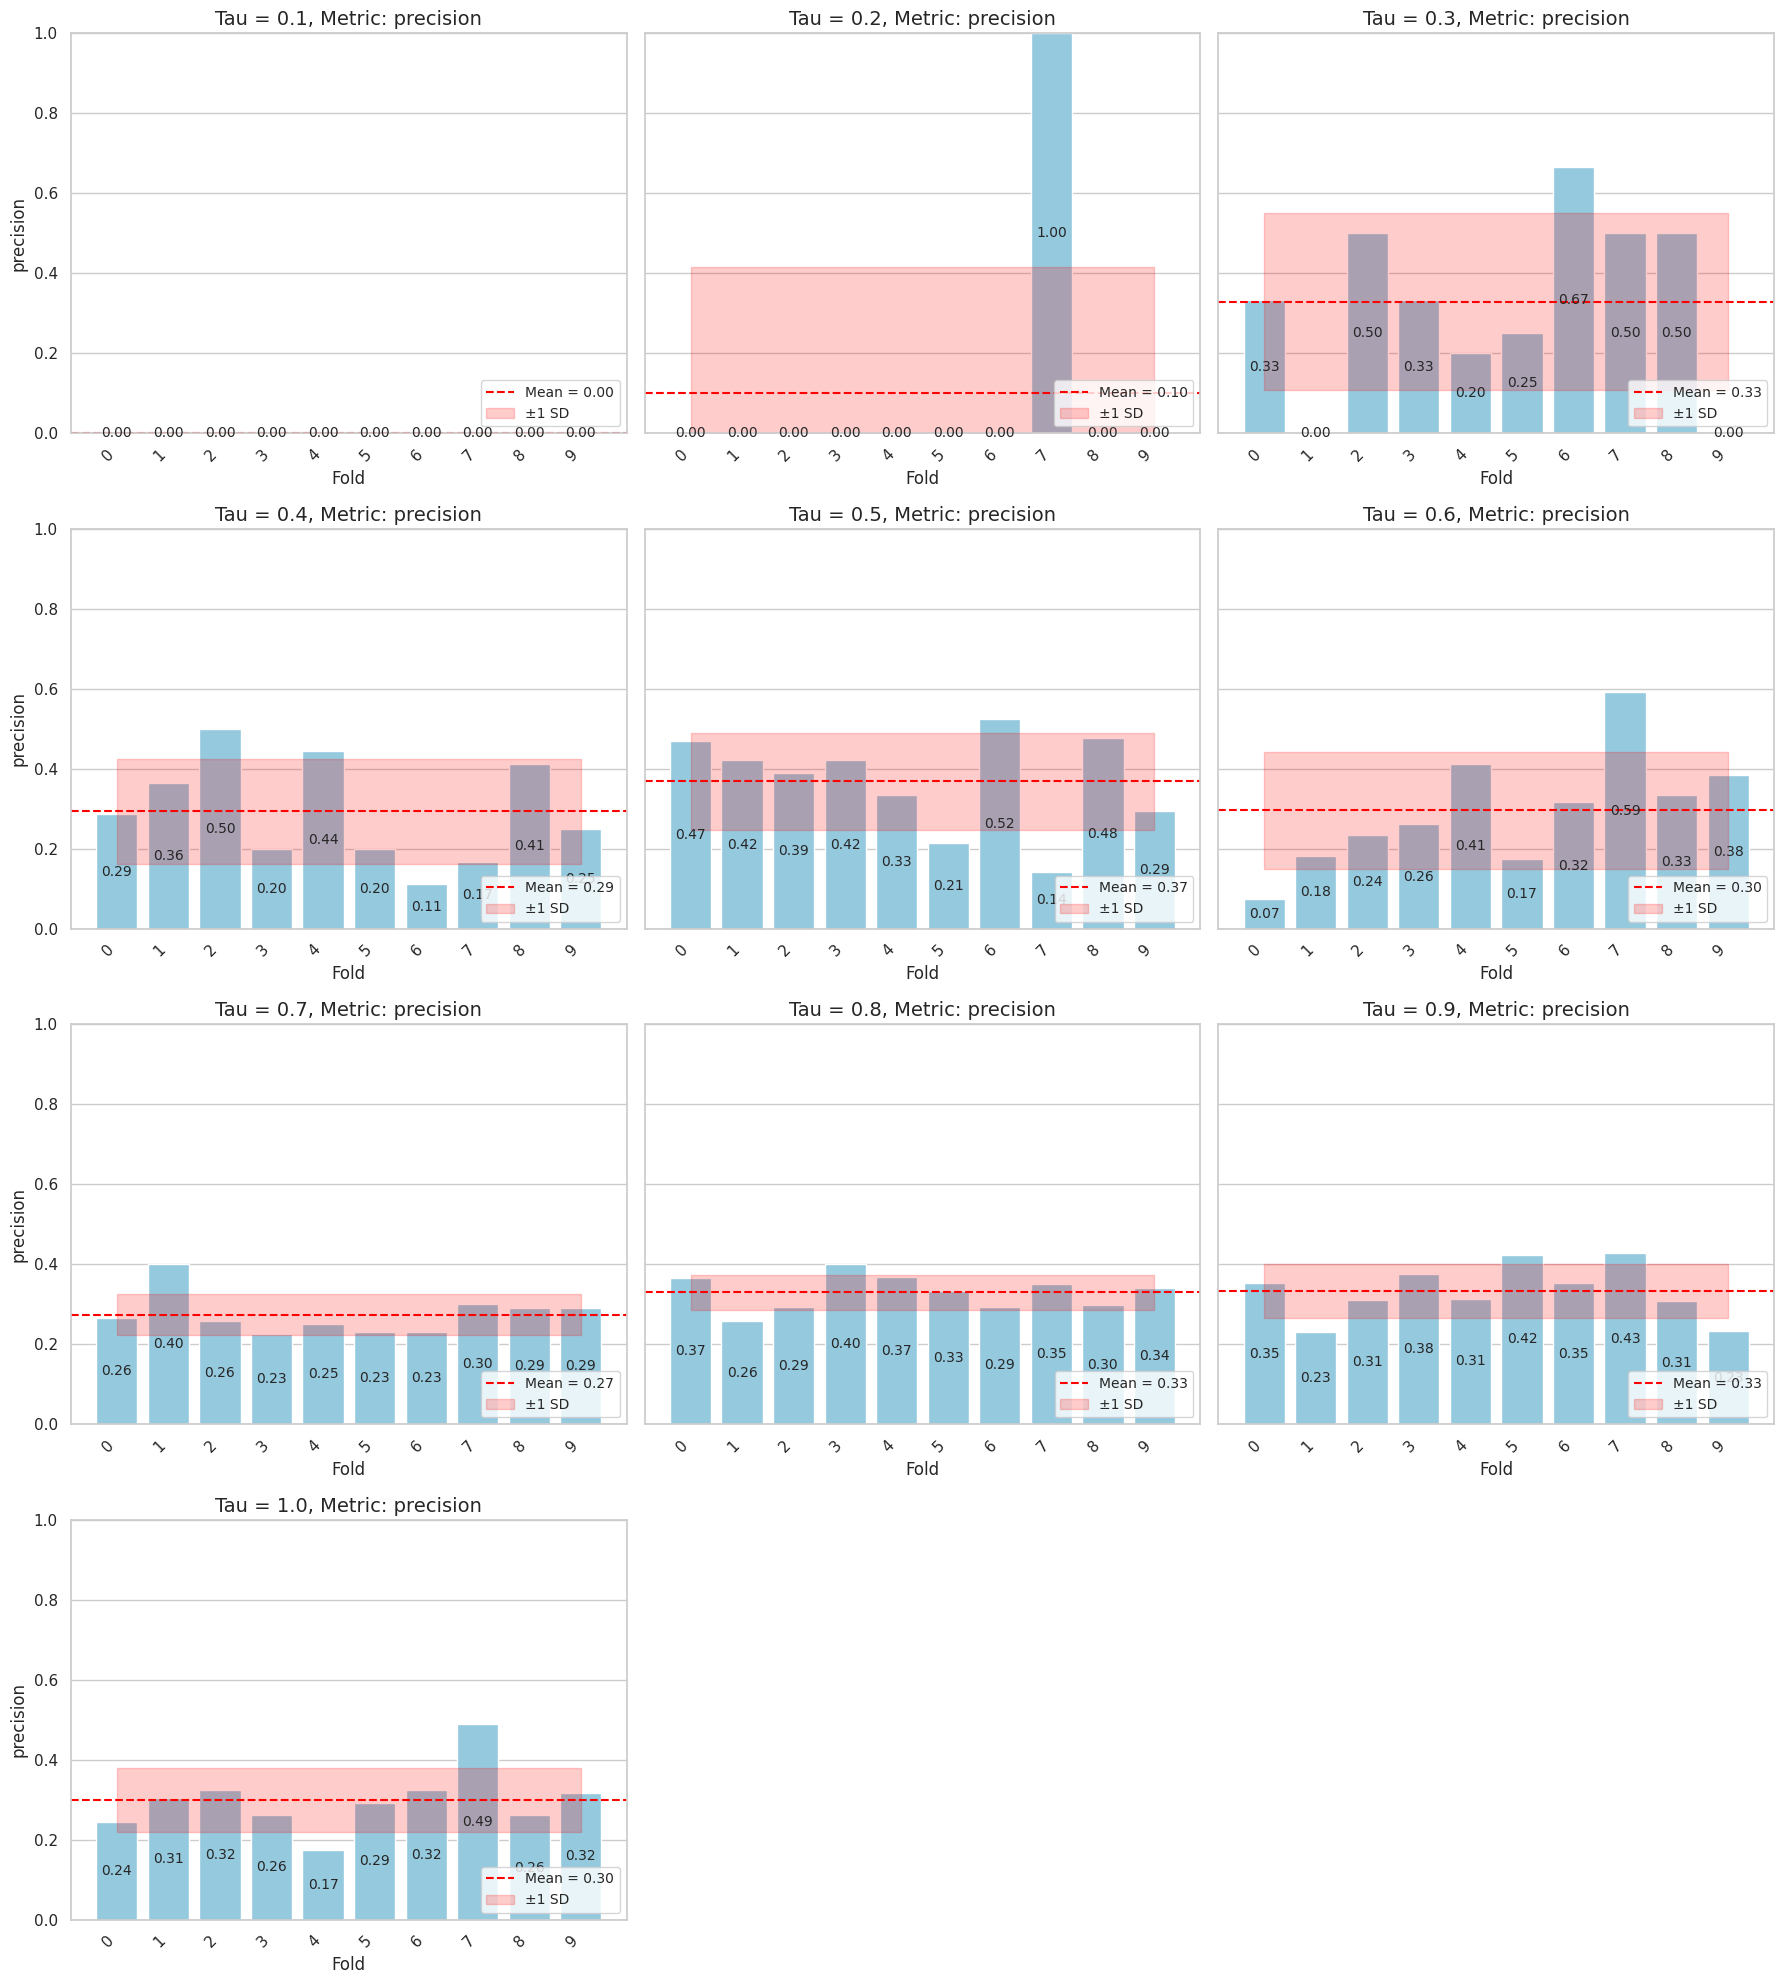

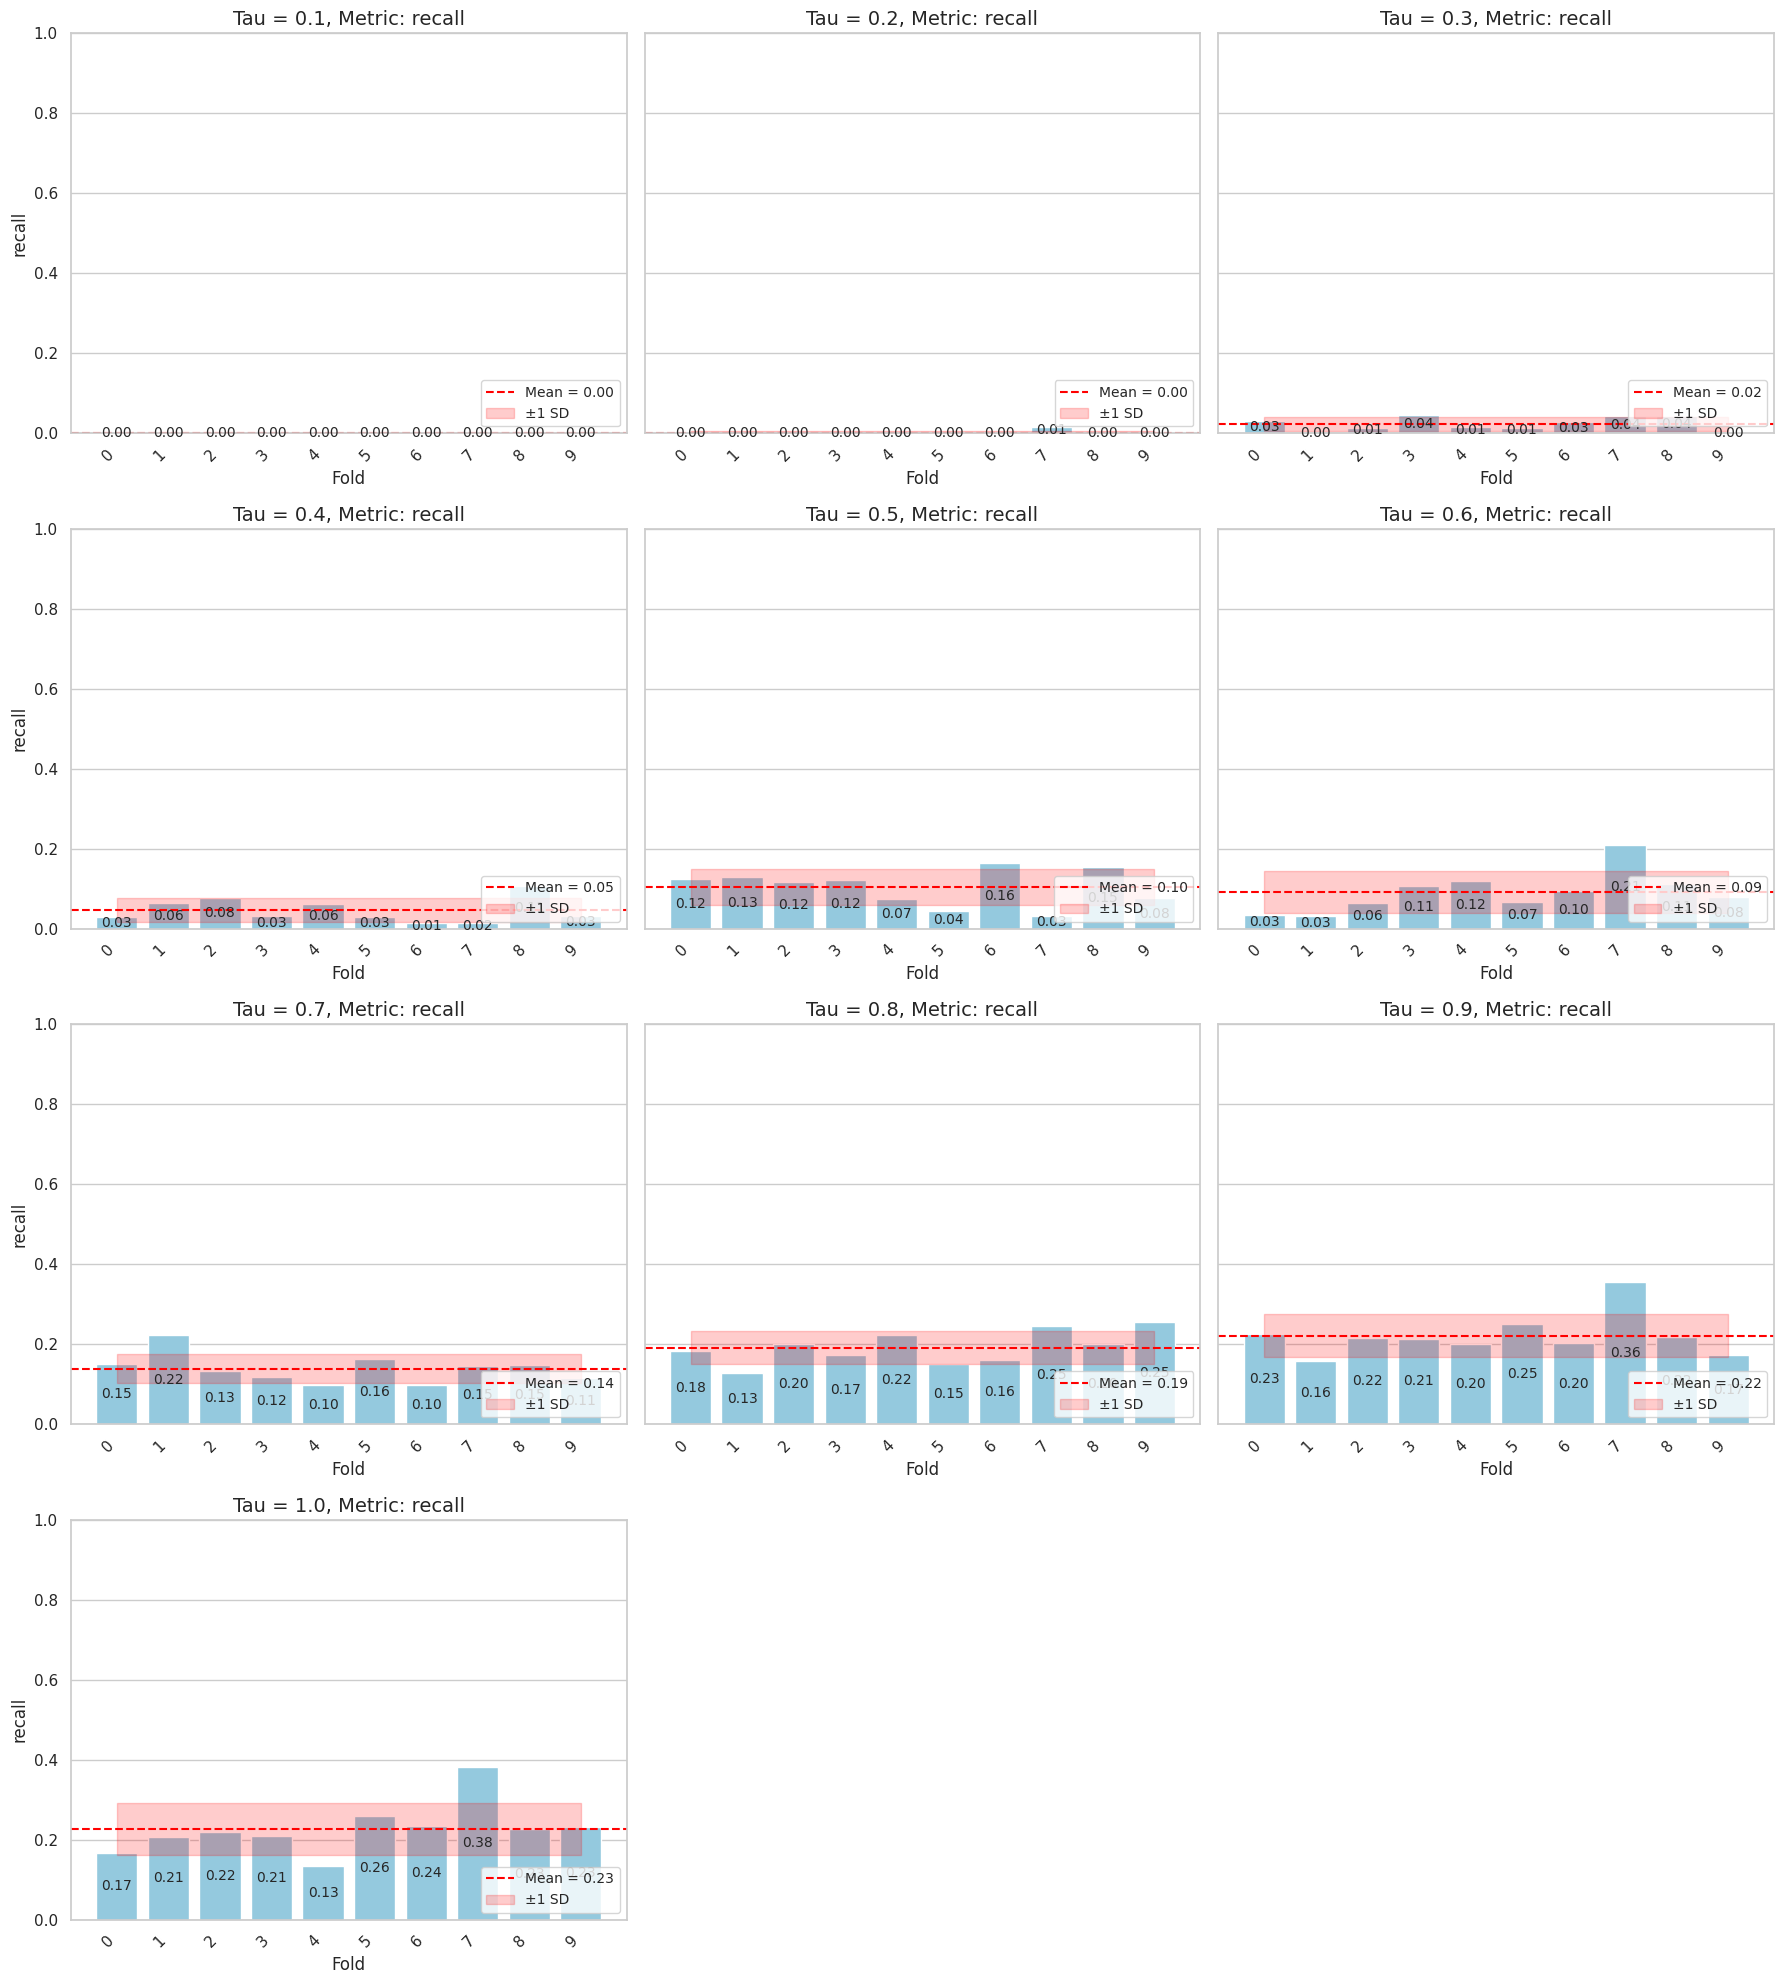

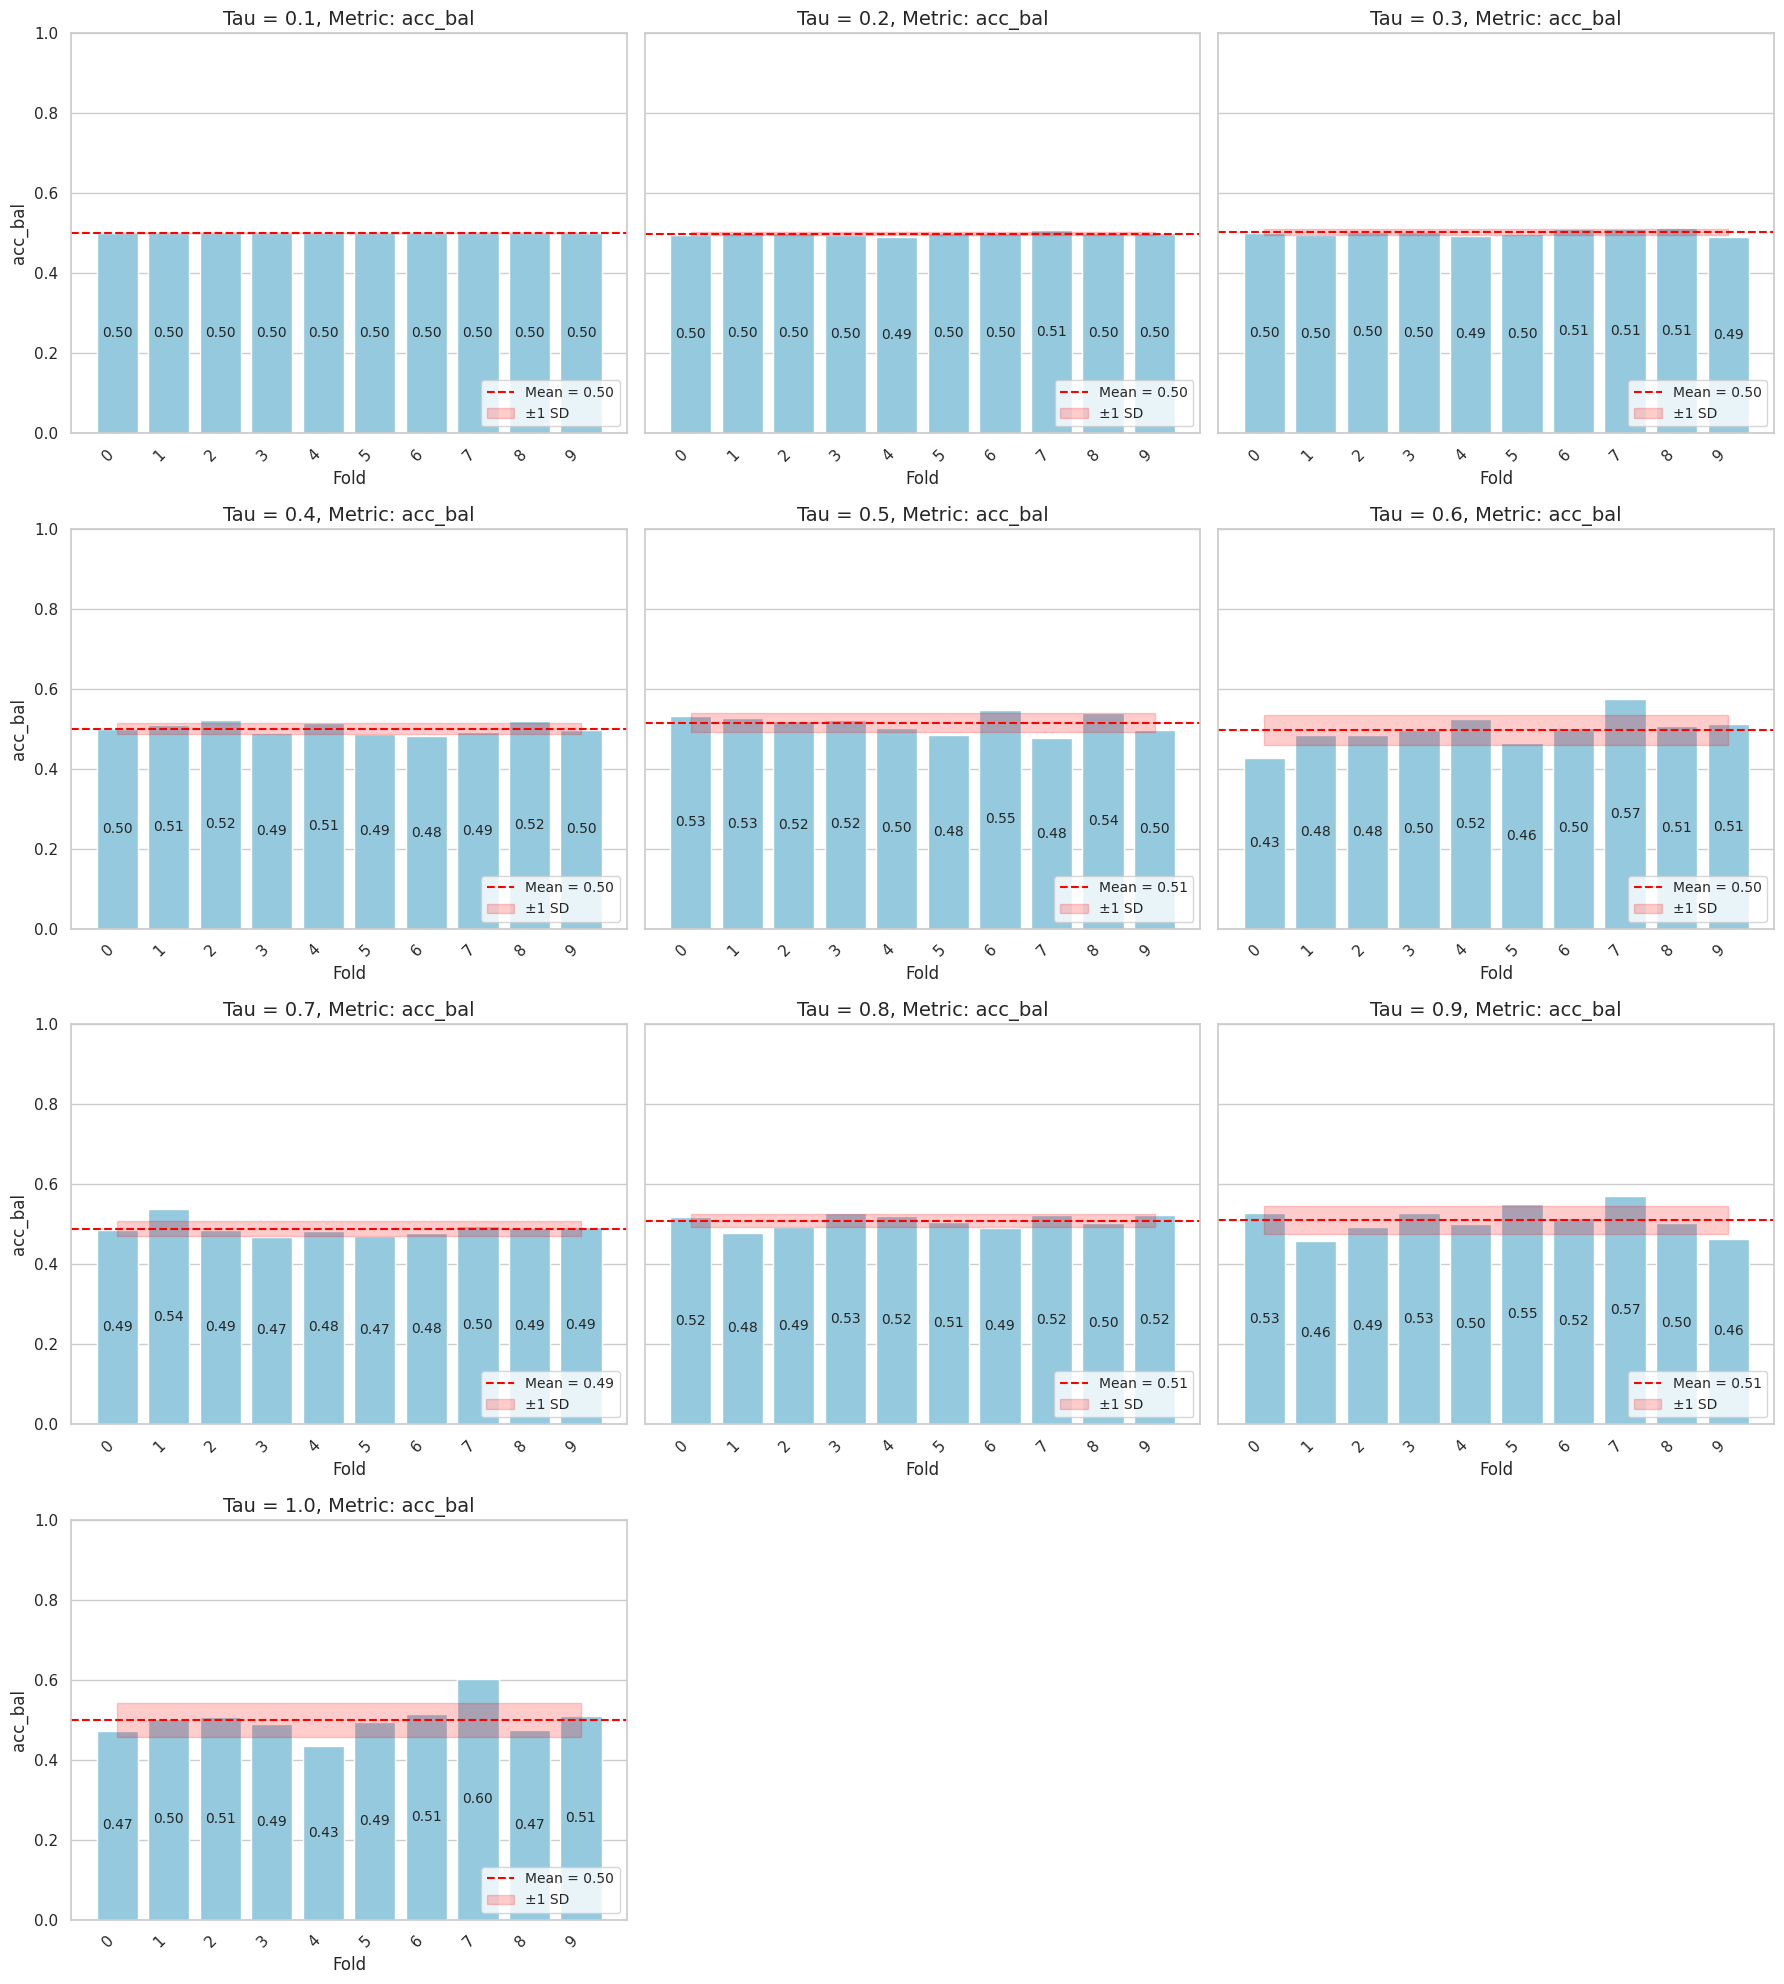

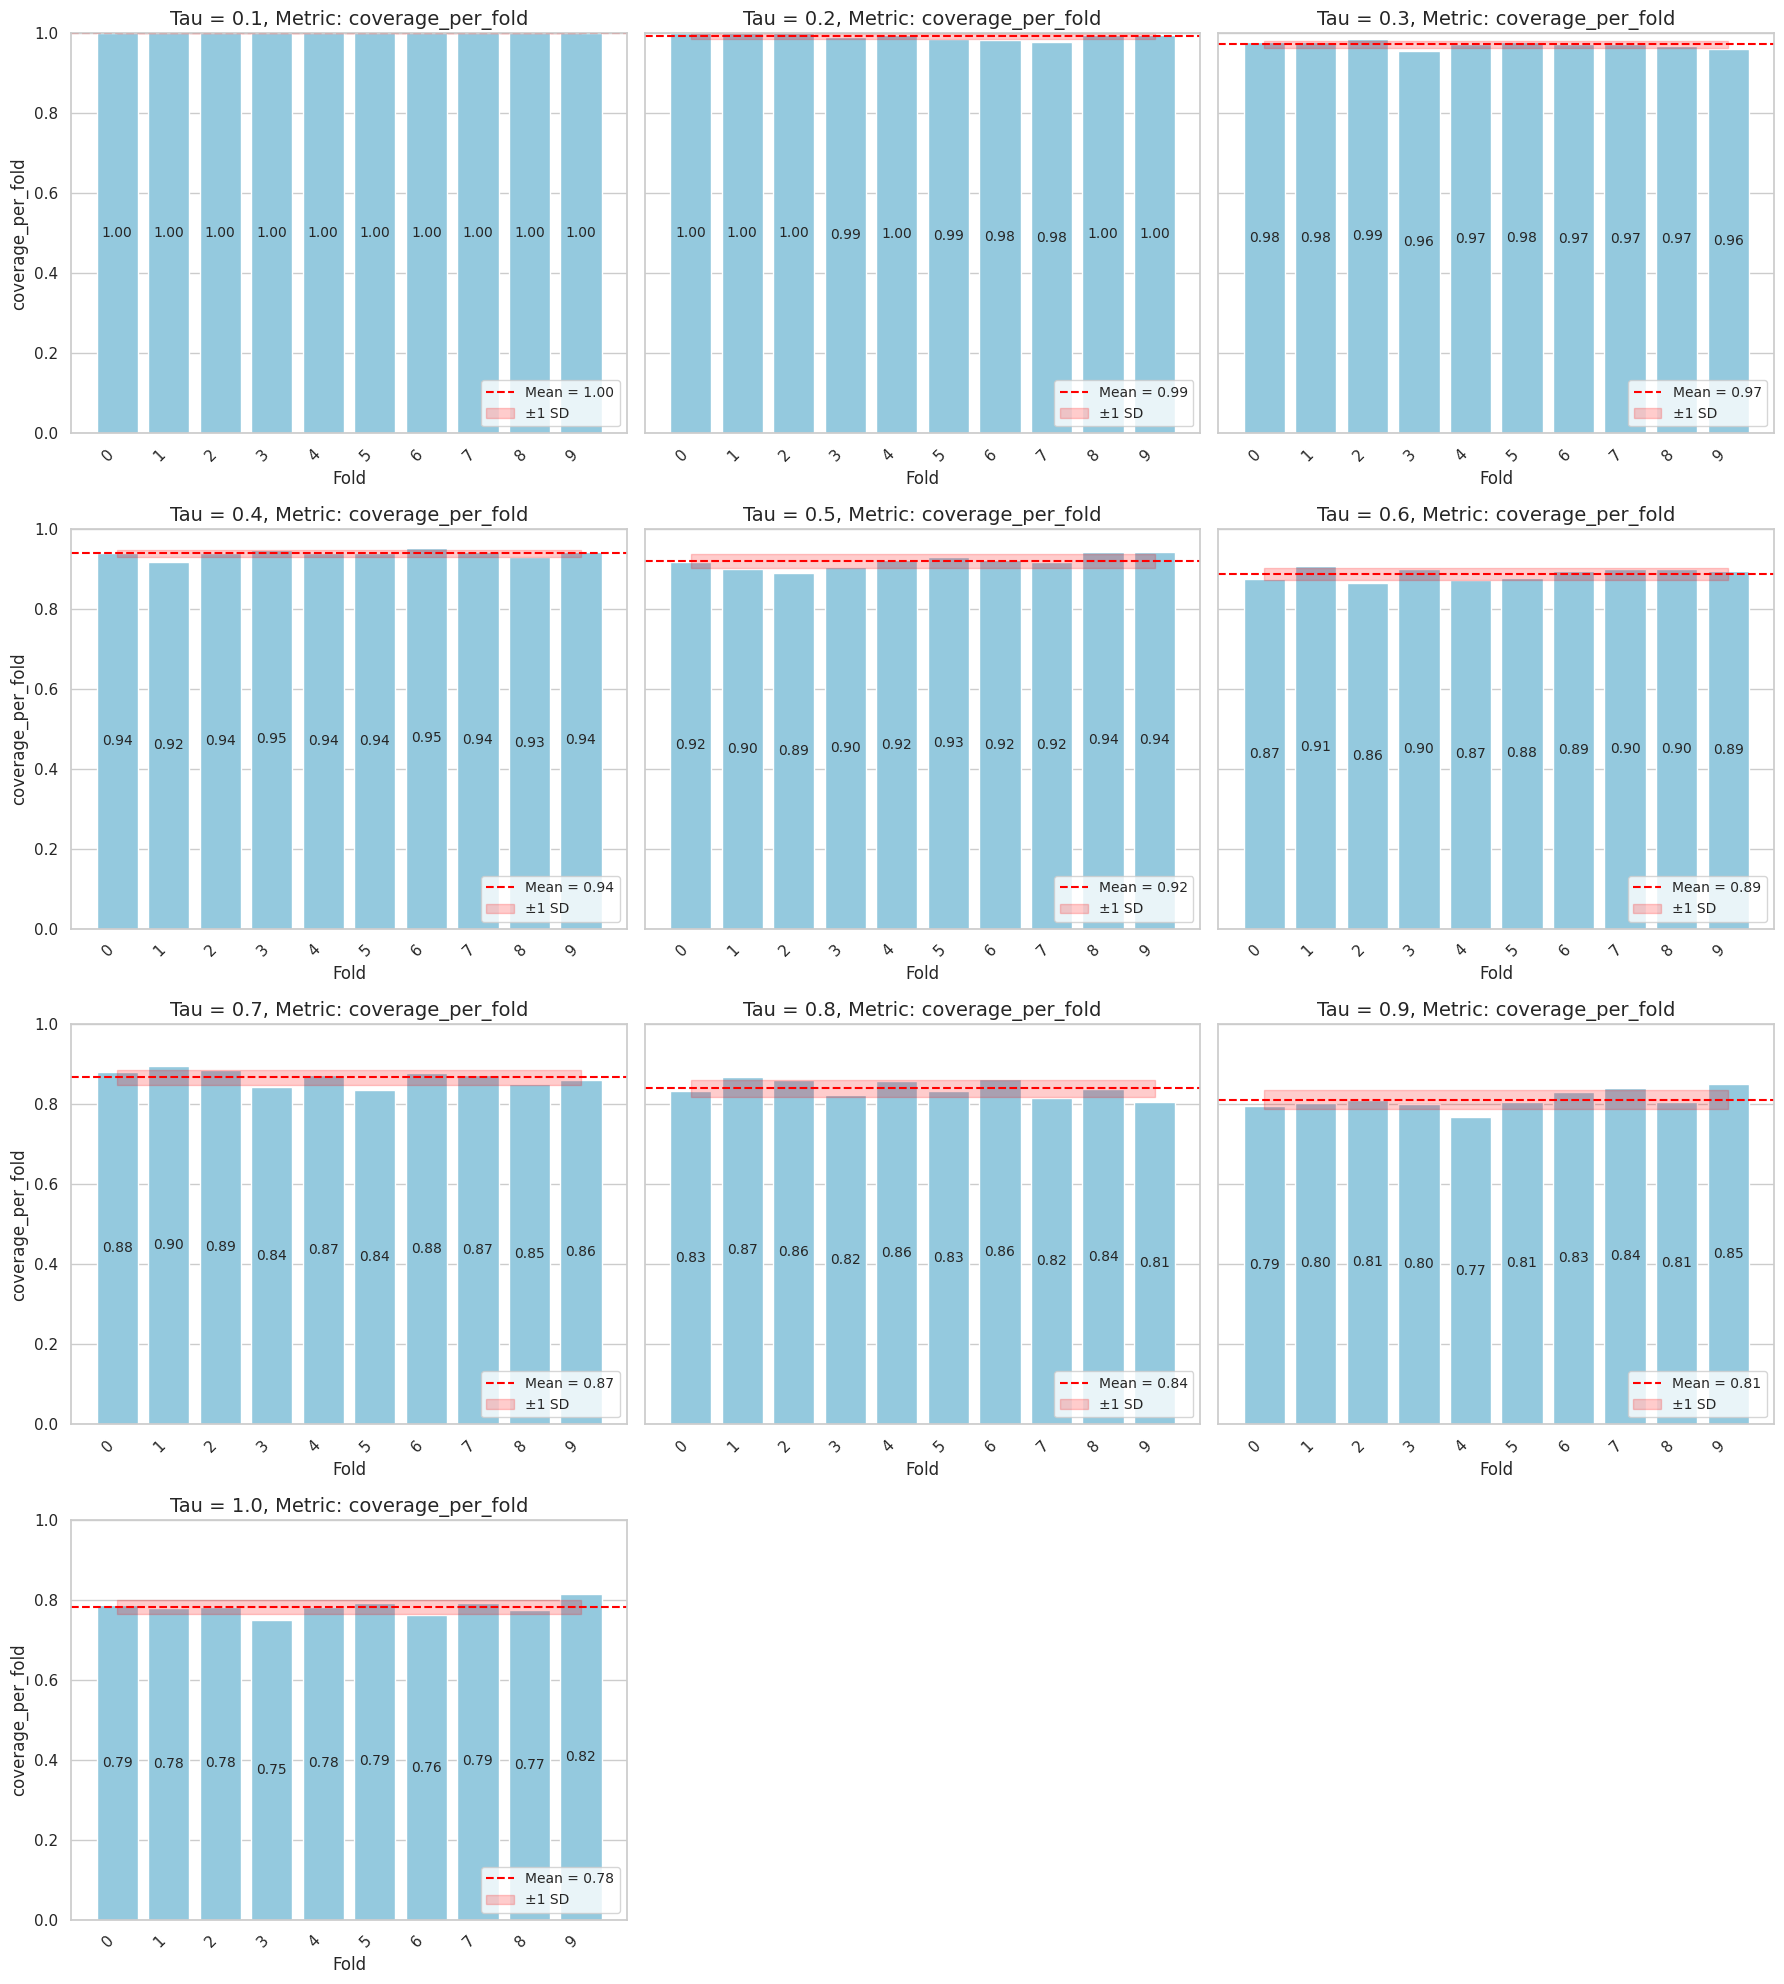

In [84]:
for i in mets:
    plot_metrics(all_metrics_deep_seek_taus_long, i)

### LONG 01 no System Instructions random shot 1

In [86]:
all_metrics_deep_seek_taus_shot1 = do_one_df_metrics_DS(filenames_construction="DS3B_random_shot1_long_version_si0_BD_mini_01/BD_mini_DS_tau_{tau}_shot_1_01_long_version.csv")
all_metrics_deep_seek_taus_shot1.head()

/.pyenv/versions/miniconda3-latest/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/.pyenv/versions/miniconda3-latest/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/.pyenv/versions/miniconda3-latest/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

fold  accuracy   f1  precision  recall  acc_bal  \
0     0  0.694323  0.0        0.0     0.0      0.5   
1     1  0.694323  0.0        0.0     0.0      0.5   
2     2  0.692982  0.0        0.0     0.0      0.5   
3     3  0.692982  0.0        0.0     0.0      0.5   
4     4  0.692982  0.0        0.0     0.0      0.5   

   number_of_answers_per_fold  coverage_per_fold  tau  
0                         229                1.0  0.1  
1                         229                1.0  0.1  
2                         228                1.0  0.1  
3                         228                1.0  0.1  
4                         228                1.0  0.1

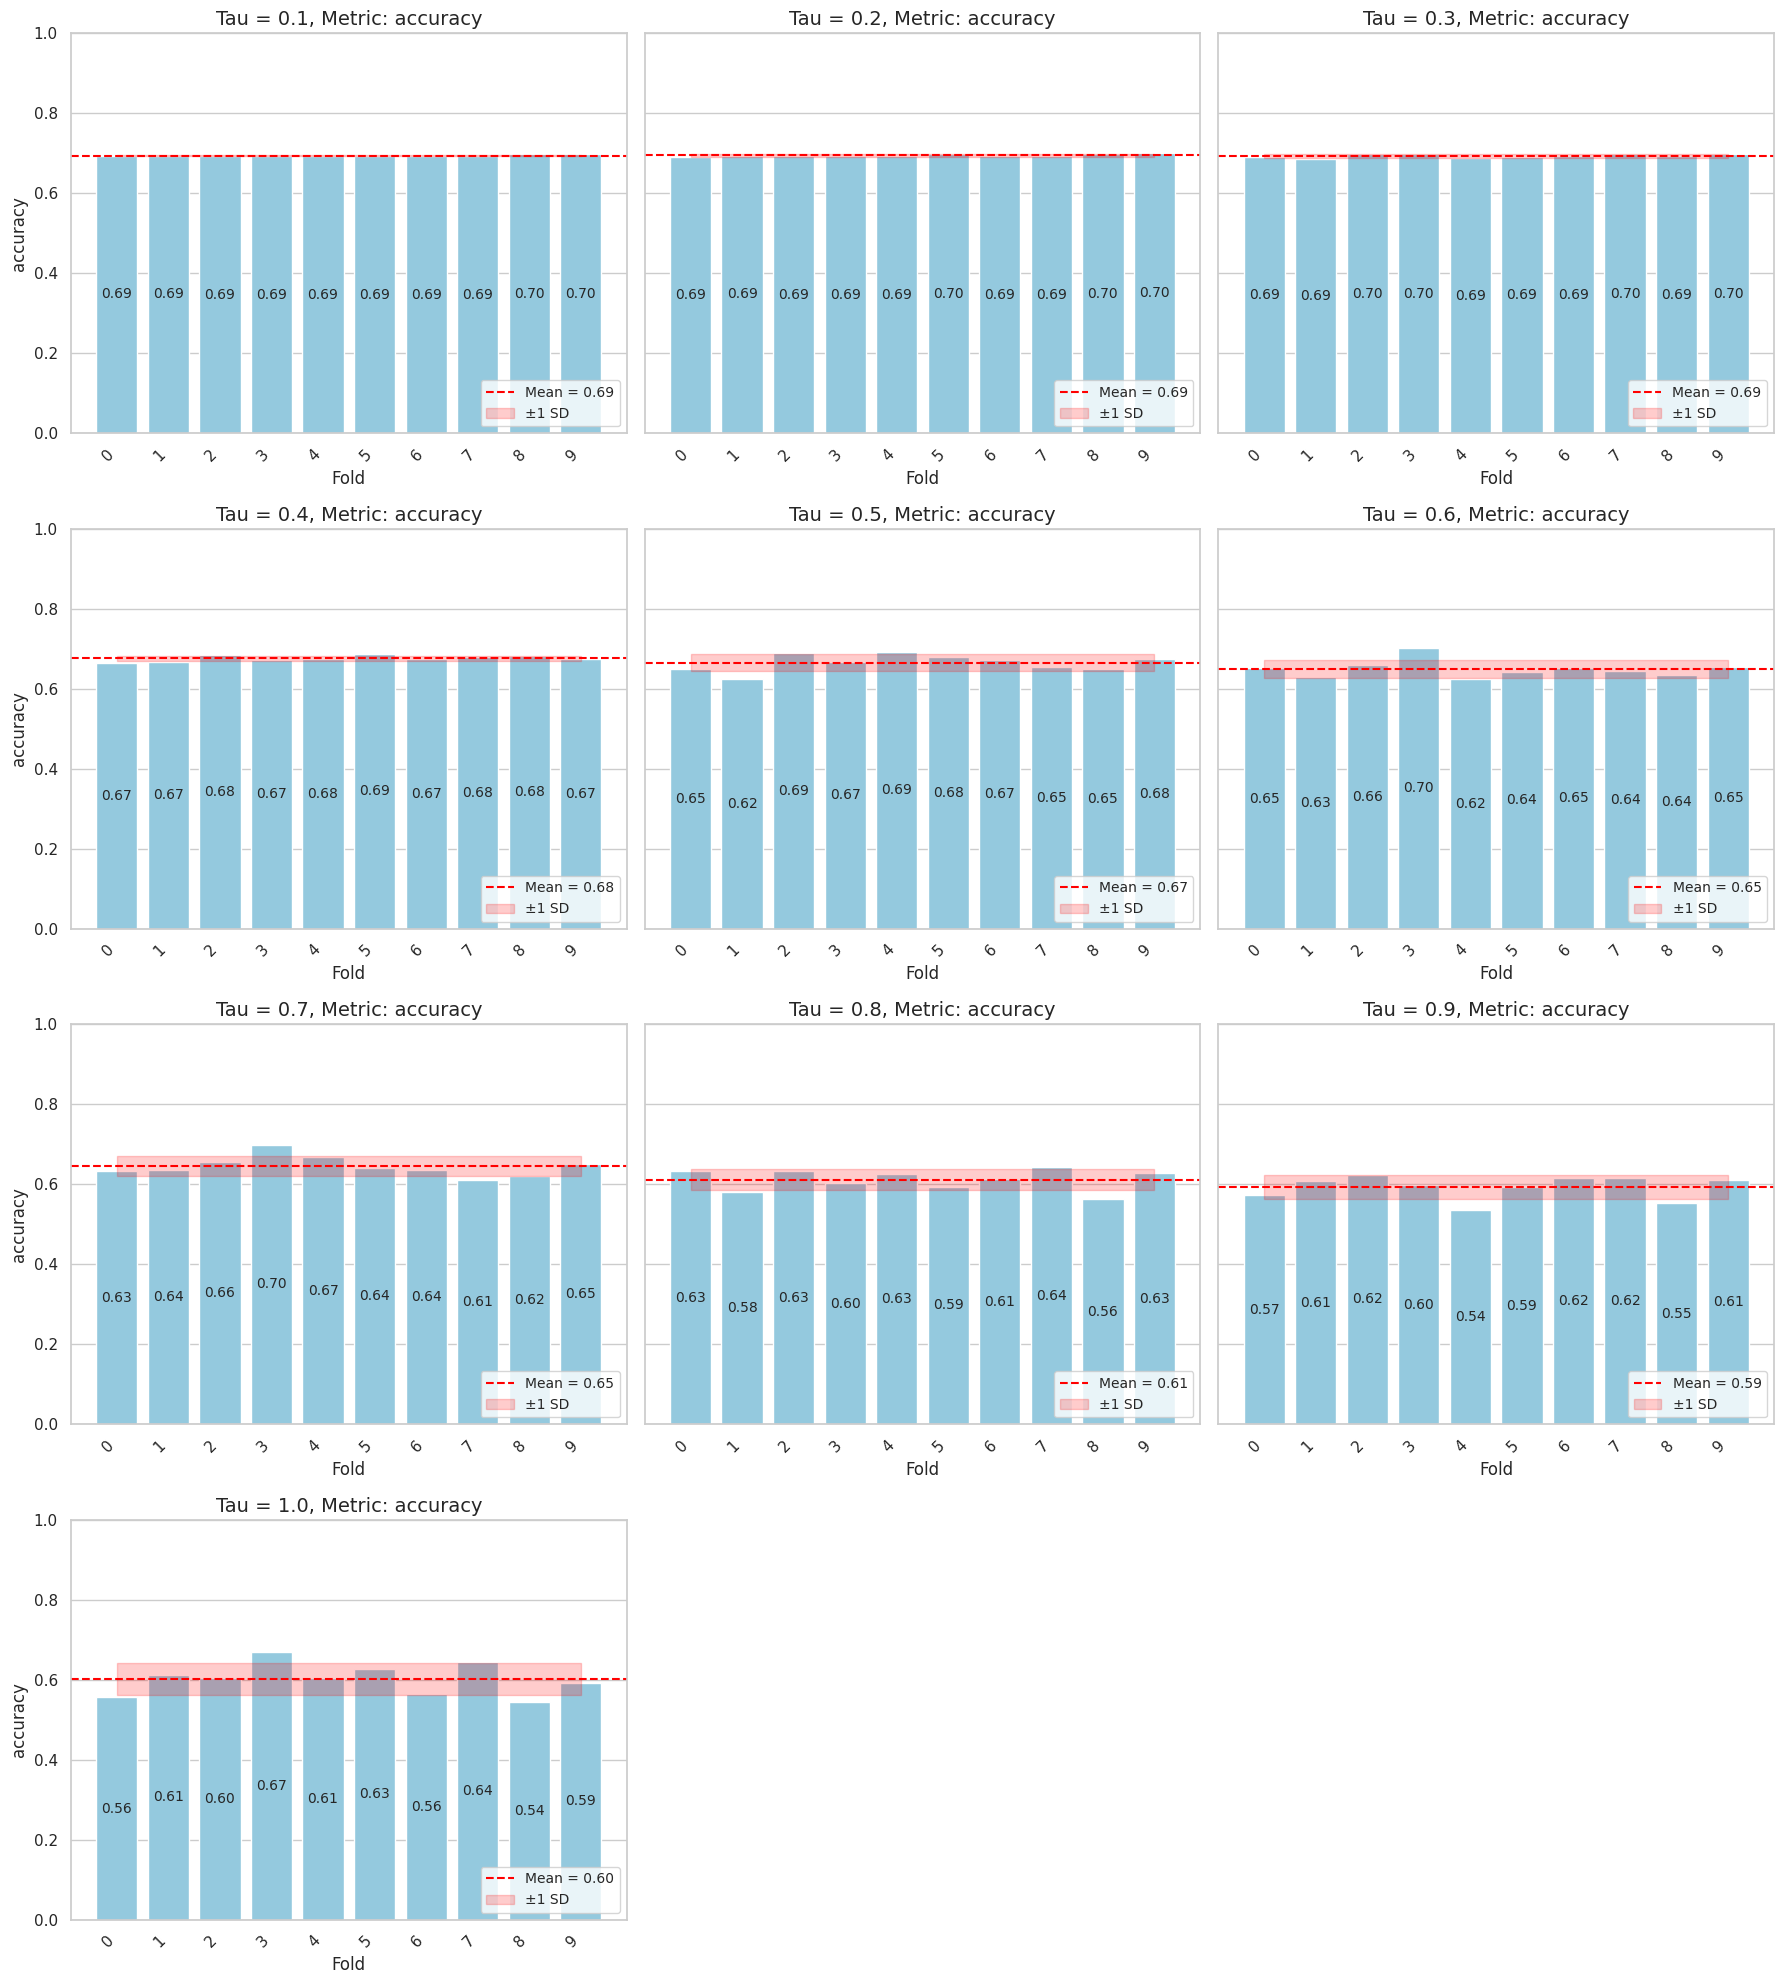

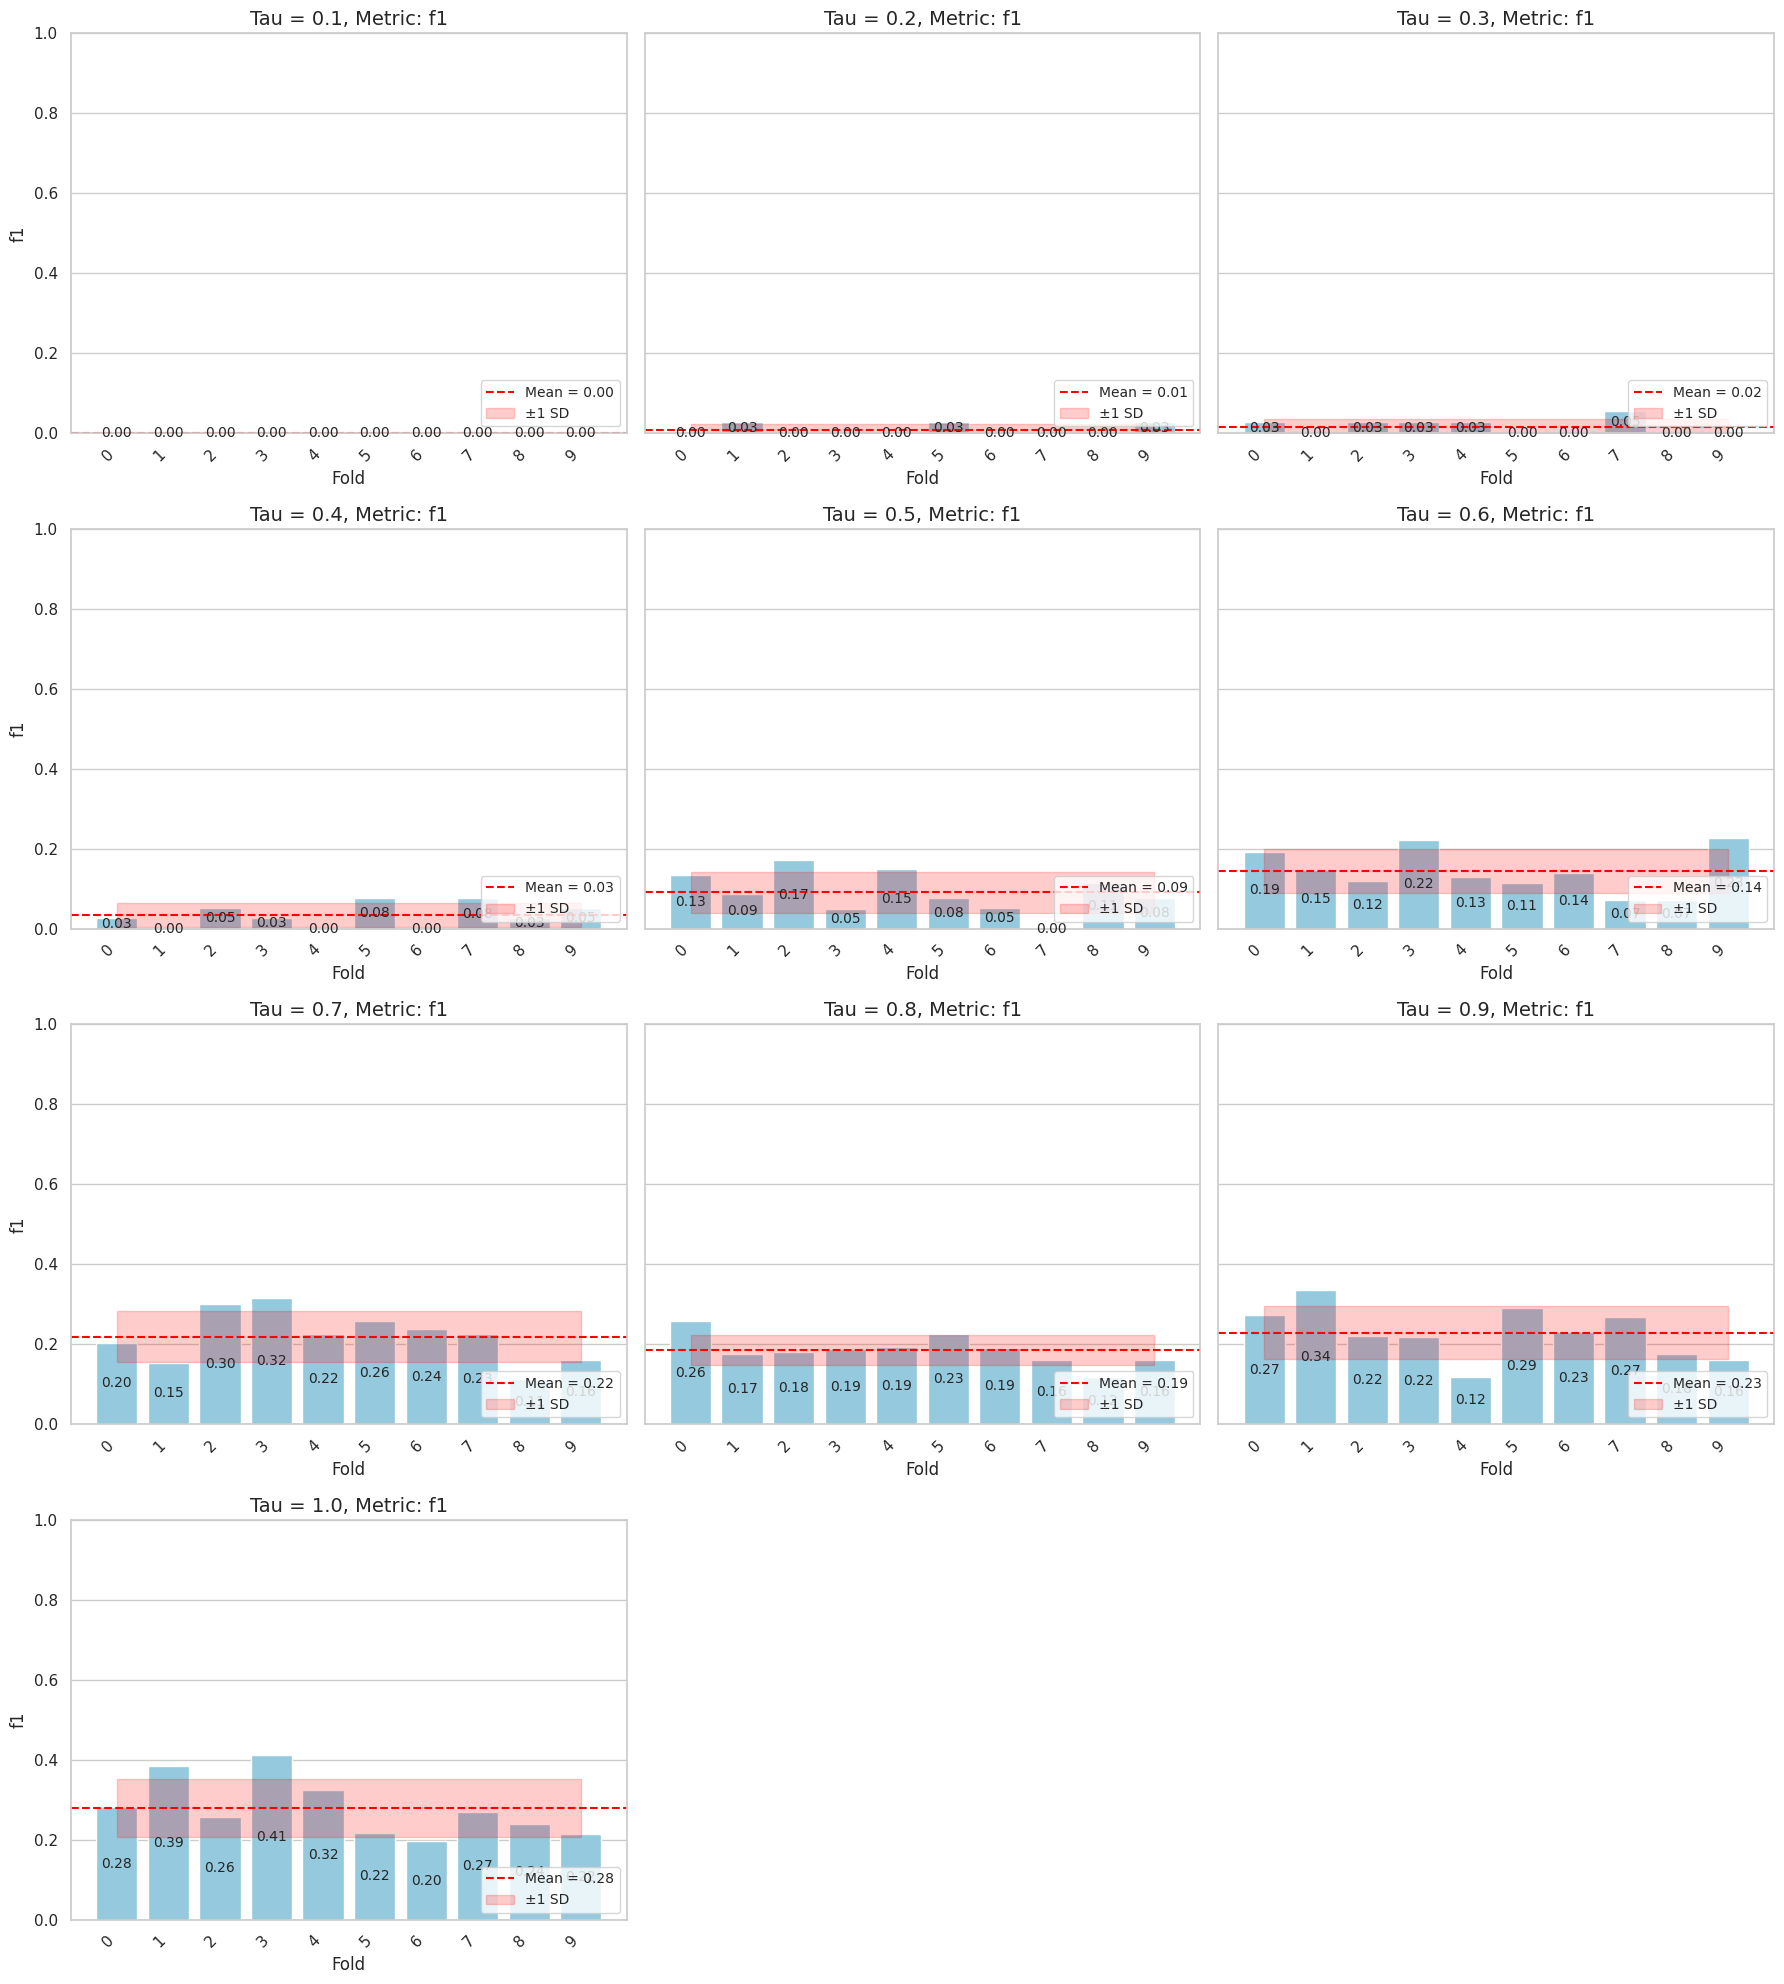

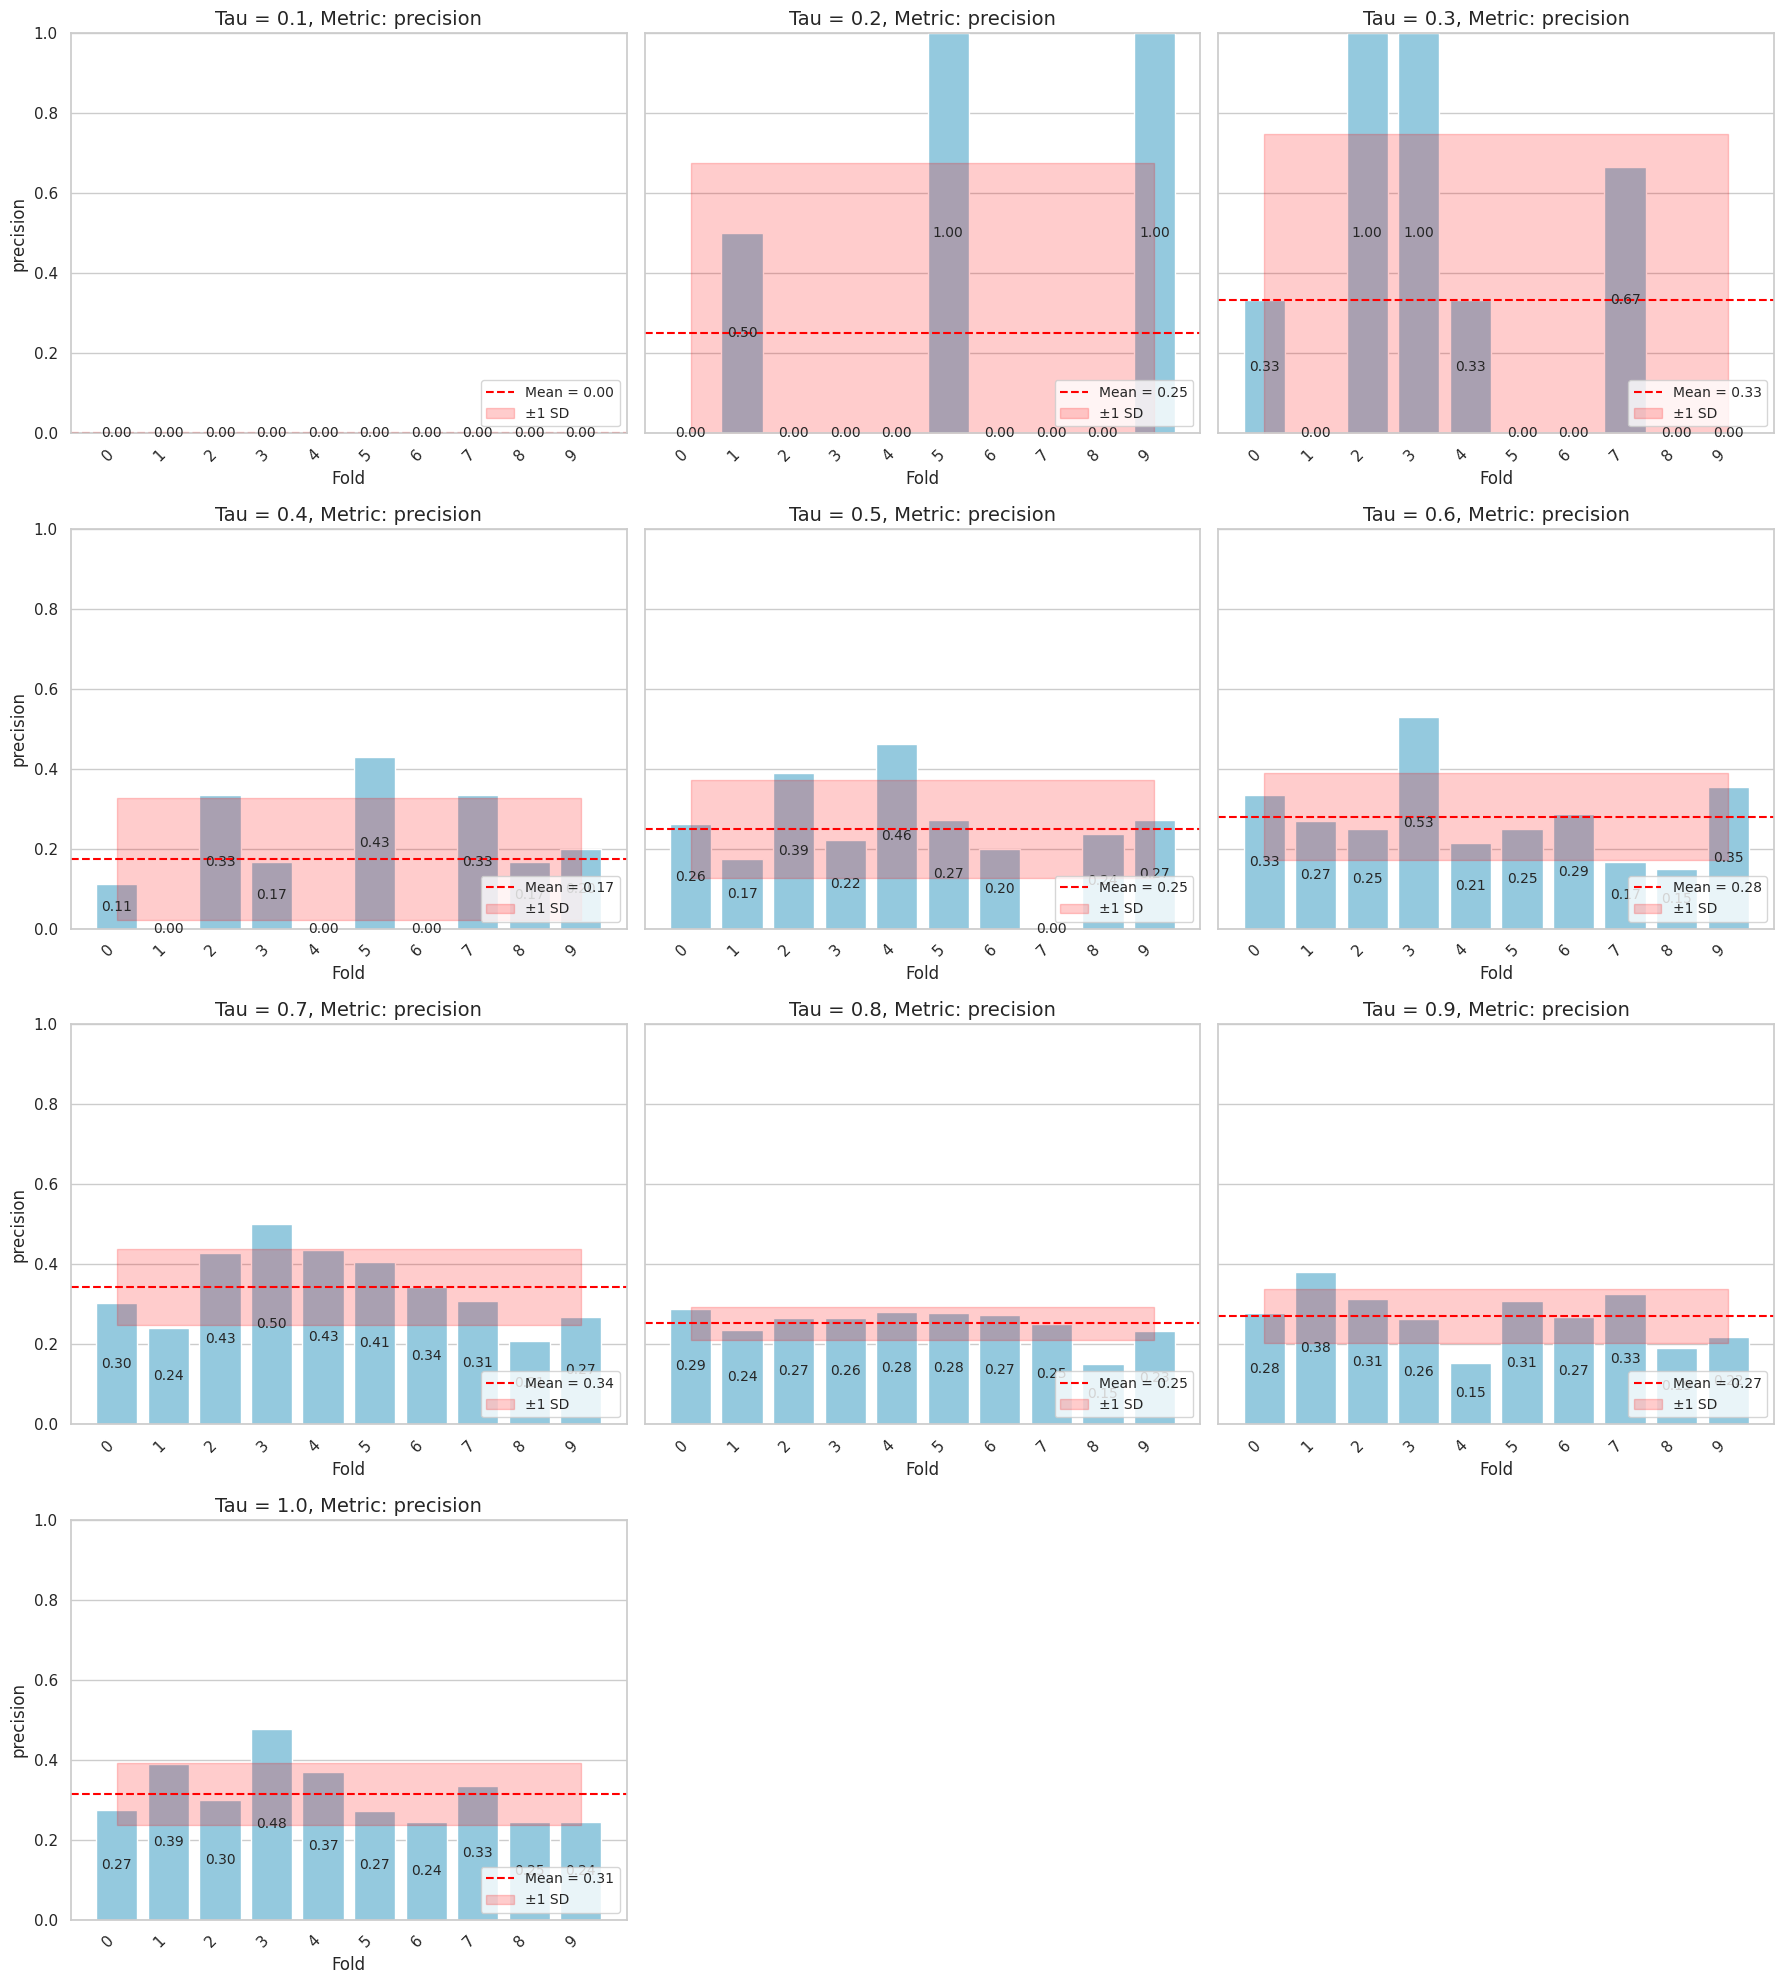

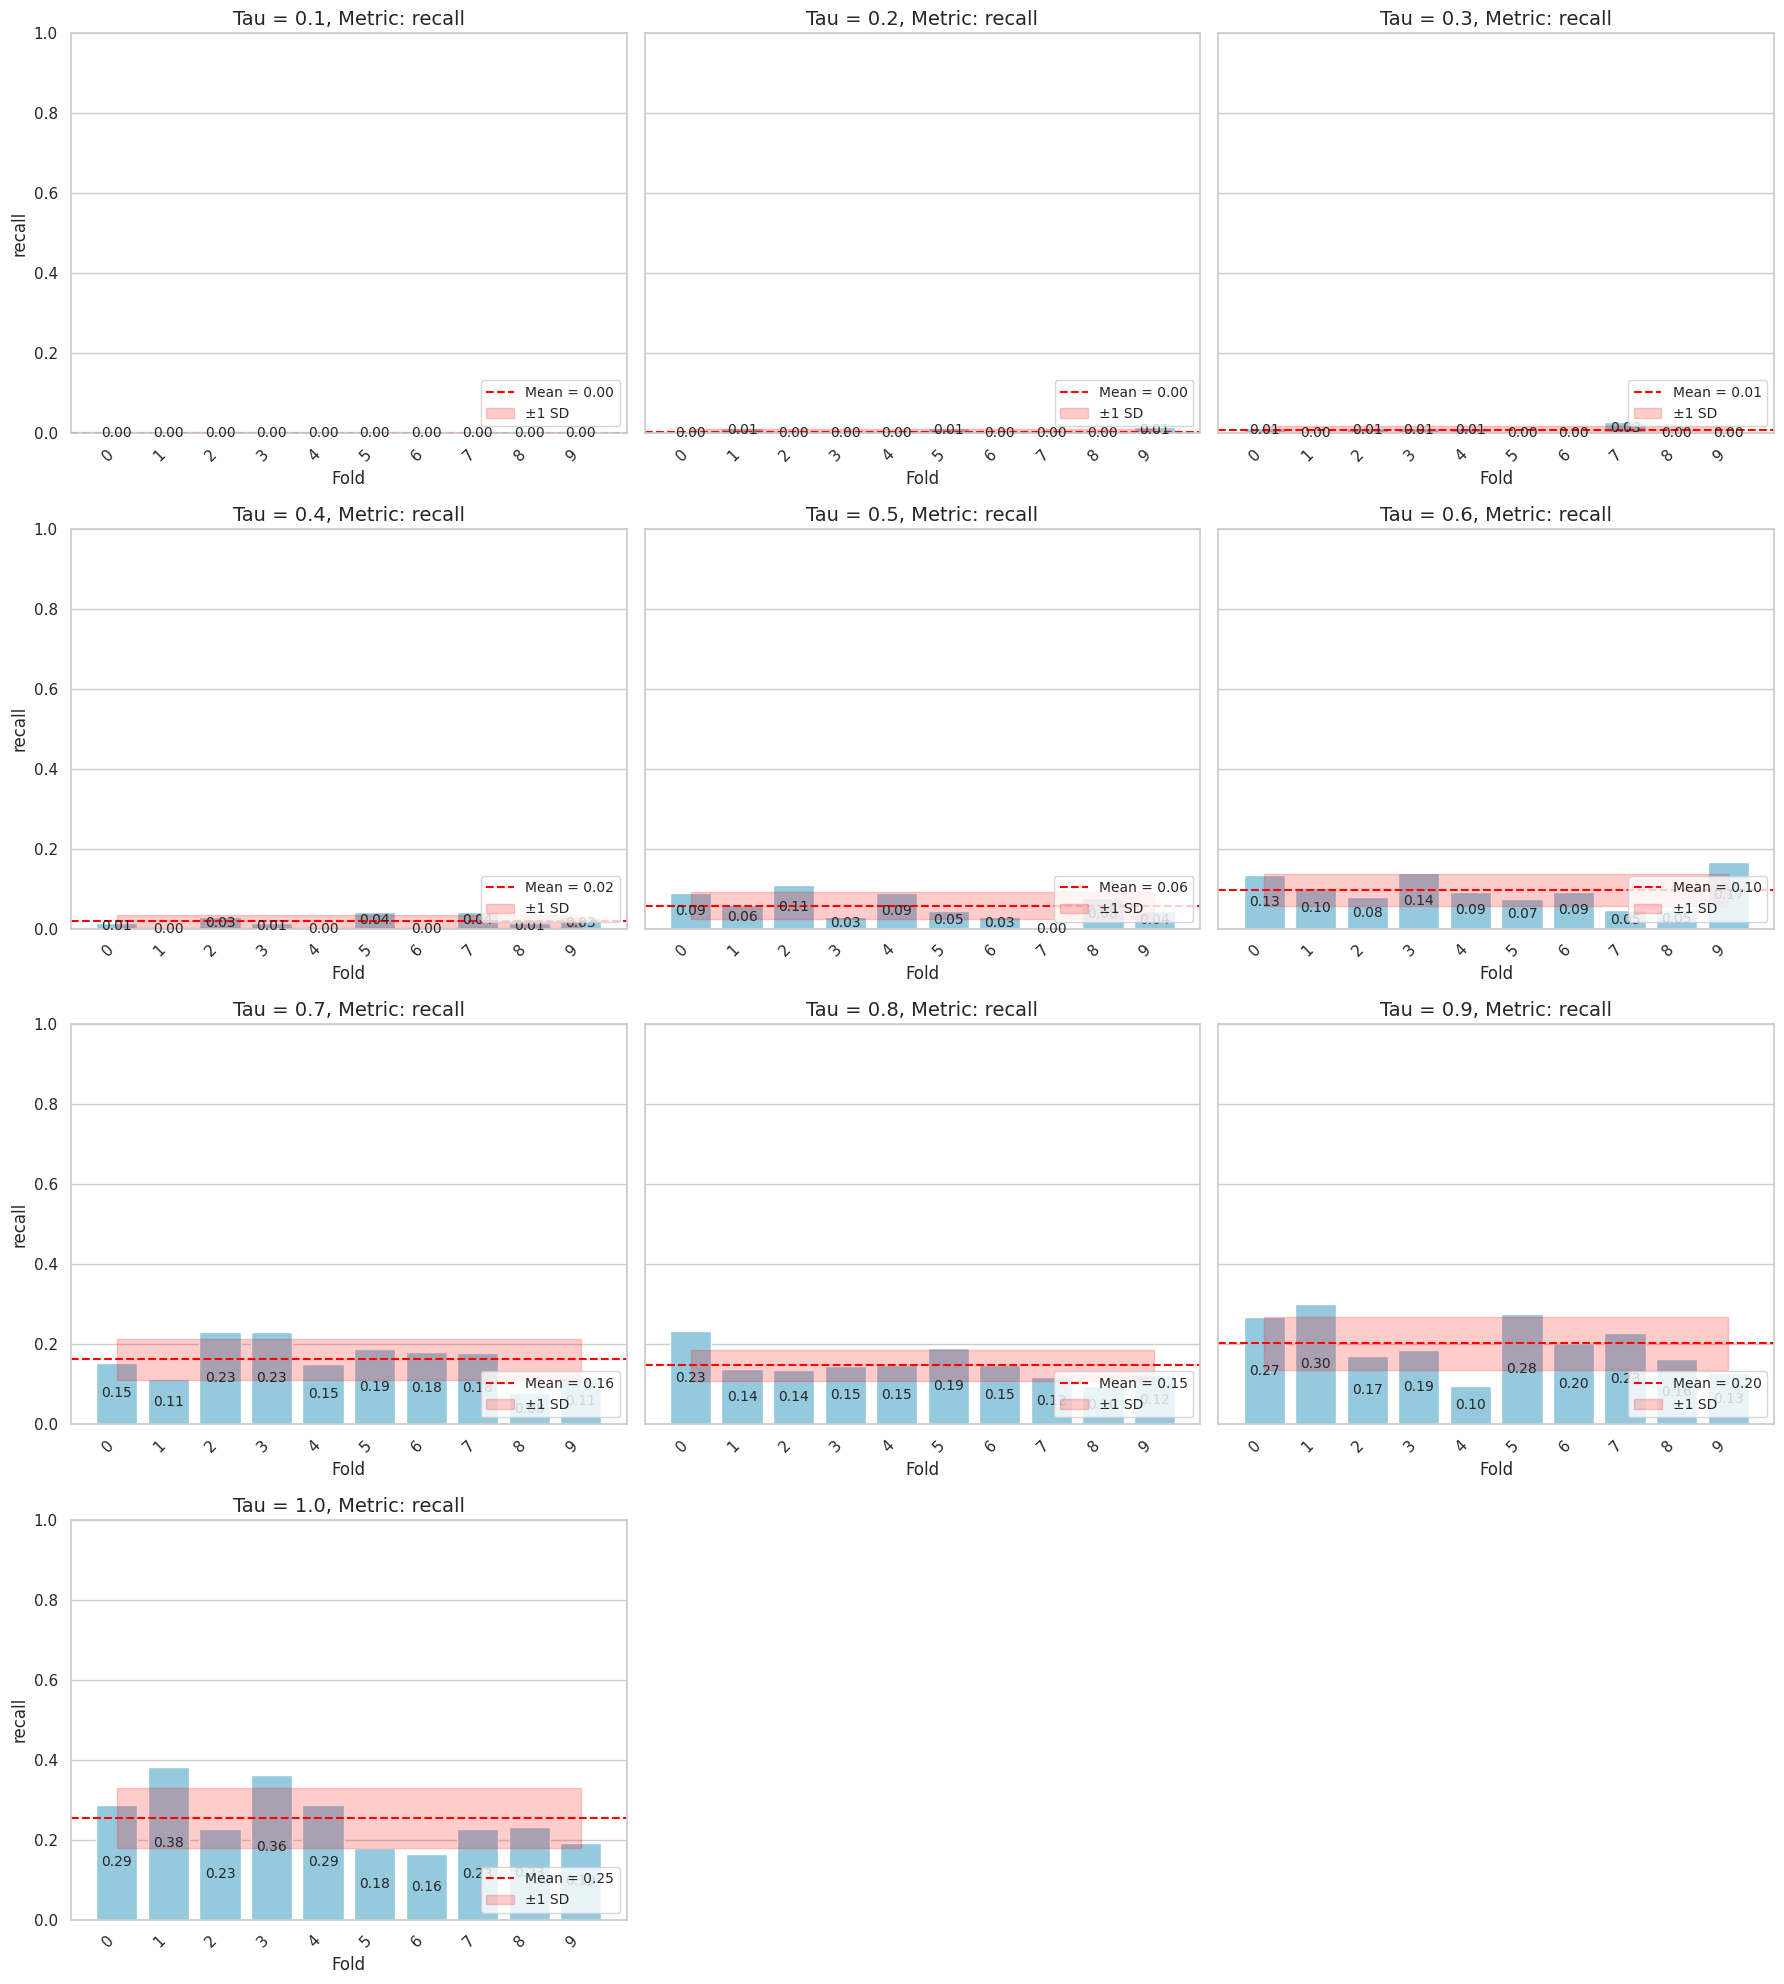

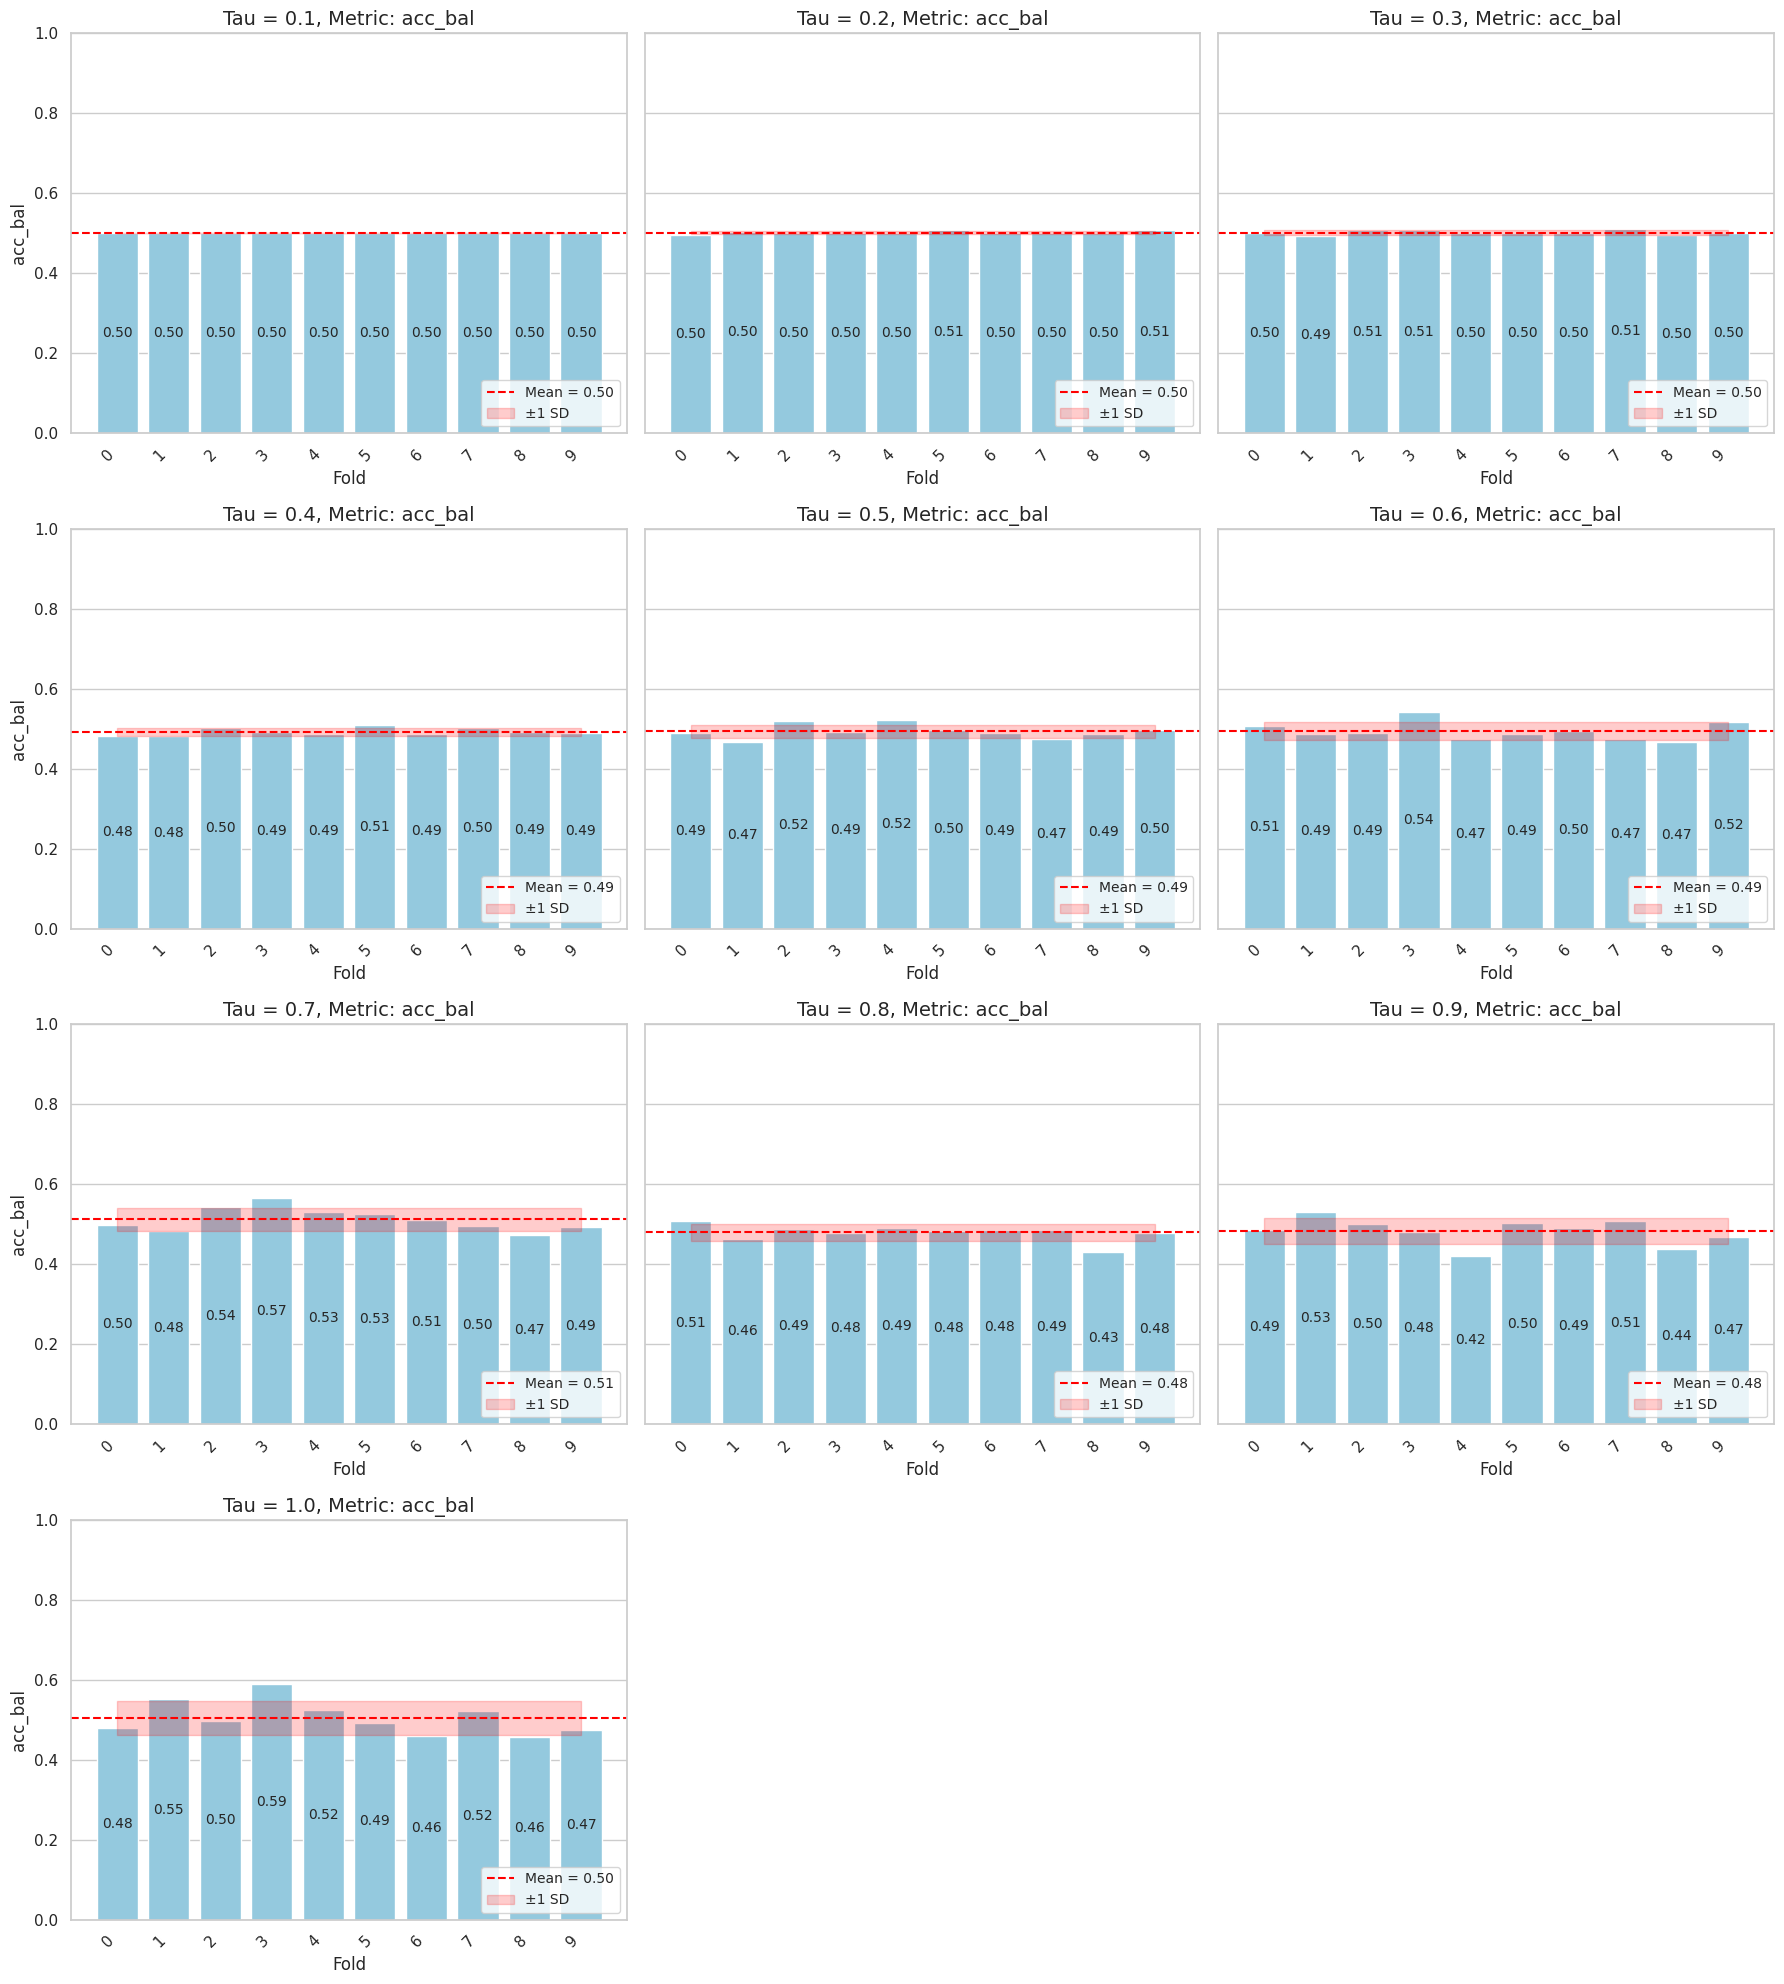

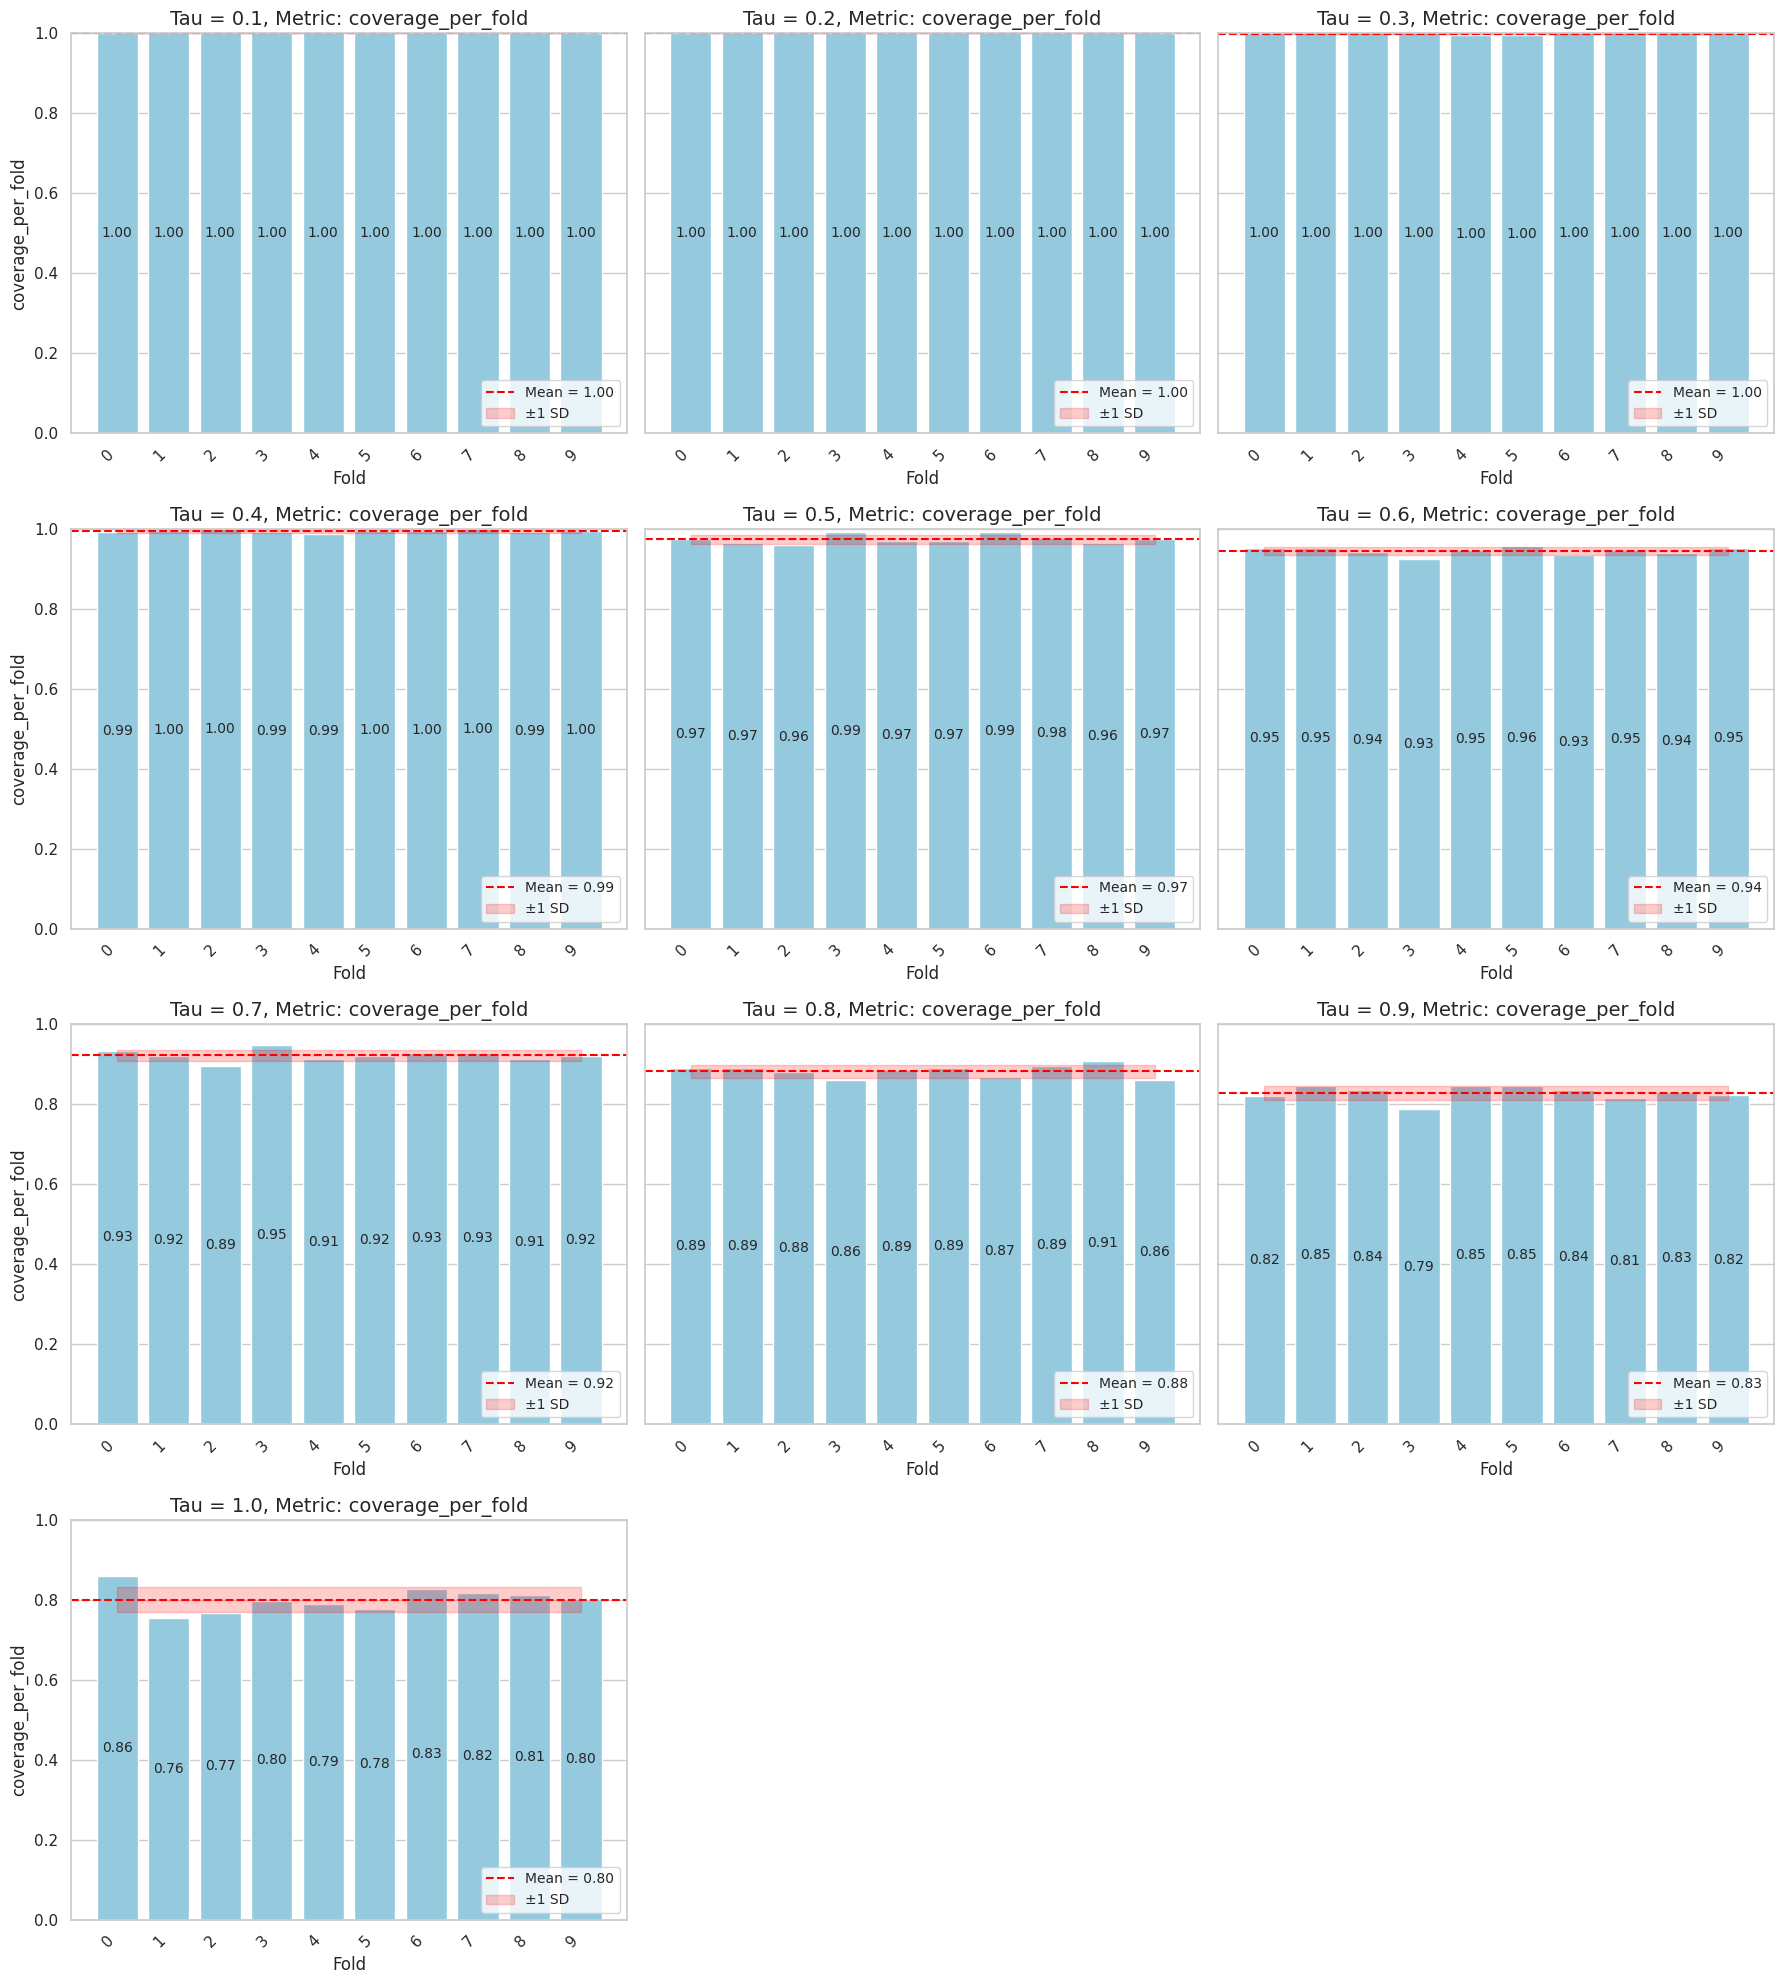

In [87]:
for i in mets:
    plot_metrics(all_metrics_deep_seek_taus_shot1, i)

### LONG 01 with System Instructions random shot 1

In [89]:
all_metrics_deep_seek_taus_long_shot1_si1 = do_one_df_metrics_DS(filenames_construction="DS3B_random_shot1_long_version_si1_BD_mini_01/BD_mini_DS_tau_{tau}_shot_1_01_long_version_si1.csv")
#all_metrics_deep_seek_taus_long_shot1_si1.head()

/.pyenv/versions/miniconda3-latest/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/.pyenv/versions/miniconda3-latest/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/.pyenv/versions/miniconda3-latest/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

fold  accuracy   f1  precision  recall  acc_bal  \
0     0  0.694323  0.0        0.0     0.0      0.5   
1     1  0.694323  0.0        0.0     0.0      0.5   
2     2  0.692982  0.0        0.0     0.0      0.5   
3     3  0.692982  0.0        0.0     0.0      0.5   
4     4  0.692982  0.0        0.0     0.0      0.5   

   number_of_answers_per_fold  coverage_per_fold  tau  
0                         229                1.0  0.1  
1                         229                1.0  0.1  
2                         228                1.0  0.1  
3                         228                1.0  0.1  
4                         228                1.0  0.1

### the rest of settings

In [135]:
all_metrics_deep_seek_taus_long_knn_shot1_si1 = do_one_df_metrics_DS(filenames_construction="DS3B_knn_shot1_long_version_si1_BD_mini_01/BD_mini_DS_tau_{tau}_shot_1_01_long_version_si1.csv")
all_metrics_deep_seek_short_taus_si1 = do_one_df_metrics_DS(filenames_construction="DS3B_shot0_short_prompt_version_si1_BD_mini_01/BD_mini_DS_tau_{tau}_01_si1.csv")
all_metrics_deep_seek_taus_long_si1 = do_one_df_metrics_DS(filenames_construction="DS3B_shot0_long_version_si1_BD_mini_01/BD_mini_DS_tau_{tau}_shot_0_01_long_version_si1.csv")
all_metrics_deep_seek_taus_long_knn_shot1_si0 = do_one_df_metrics_DS(filenames_construction="DS3B_knn_shot1_long_version_si0_BD_mini_01/BD_mini_DS_tau_{tau}_shot_1_01_long_version_si0.csv")

/.pyenv/versions/miniconda3-latest/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/.pyenv/versions/miniconda3-latest/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/.pyenv/versions/miniconda3-latest/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

### after retry for some settings

In [142]:
all_metrics_deep_seek_taus_long_shot1_si1_retry = do_one_df_metrics_DS(filenames_construction="DS3B_random_shot1_long_version_si1_BD_mini_01/BD_mini_DS_tau_{tau}_shot_1_01_long_version_si1_retry.csv")
all_metrics_deep_seek_short_taus_si1_retry = do_one_df_metrics_DS(filenames_construction="DS3B_shot0_short_prompt_version_si1_BD_mini_01/BD_mini_DS_tau_{tau}_01_si1_retry.csv")
all_metrics_deep_seek_taus_long_si1_retry = do_one_df_metrics_DS(filenames_construction="DS3B_shot0_long_version_si1_BD_mini_01/BD_mini_DS_tau_{tau}_01_long_si1_retry.csv")
all_metrics_deep_seek_taus_long_knn_shot1_si0_retry = do_one_df_metrics_DS(filenames_construction="DS3B_knn_shot1_long_version_si0_BD_mini_01/BD_mini_DS_tau_{tau}_shot_1_01_long_version_si0_retry.csv")

/.pyenv/versions/miniconda3-latest/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/.pyenv/versions/miniconda3-latest/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/.pyenv/versions/miniconda3-latest/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

In [148]:
metrics = [
    'accuracy', 'f1', 'precision',
    'recall', 'acc_bal', 'coverage_per_fold'
]

df_short = all_metrics_deep_seek_short_taus.copy()
df_short['setting'] = 'short_shot_0'

df_short_si = all_metrics_deep_seek_short_taus_si1.copy()
df_short_si['setting'] = 'short_shot_0_si'

df_short_si_retry = all_metrics_deep_seek_short_taus_si1_retry.copy()
df_short_si_retry['setting'] = 'short_shot_0_si_retry'

df_long = all_metrics_deep_seek_taus_long.copy()
df_long['setting'] = 'long_shot_0'

df_long_si = all_metrics_deep_seek_taus_long_si1.copy()
df_long_si['setting'] = 'long_shot_0_si'

df_long_si_retry = all_metrics_deep_seek_taus_long_si1_retry.copy()
df_long_si_retry['setting'] = 'long_shot_0_si_retry'

df_shot1 = all_metrics_deep_seek_taus_shot1.copy()
df_shot1['setting'] = 'long_r_shot_1'

df_shot1_si1 = all_metrics_deep_seek_taus_long_shot1_si1_retry.copy()
df_shot1_si1['setting'] = 'long_r_shot_1_si_1'

df_shot1_si1_retry = all_metrics_deep_seek_taus_long_shot1_si1.copy()
df_shot1_si1_retry['setting'] = 'long_r_shot_1_si_1_retry'

df_shot1_knn_si0 = all_metrics_deep_seek_taus_long_knn_shot1_si0.copy()
df_shot1_knn_si0['setting'] = 'long_knn_shot_1'

df_shot1_knn_si0_retry = all_metrics_deep_seek_taus_long_knn_shot1_si0_retry.copy()
df_shot1_knn_si0_retry['setting'] = 'long_knn_shot_1_retry'

df_shot1_knn_si1 = all_metrics_deep_seek_taus_long_knn_shot1_si1.copy()
df_shot1_knn_si1['setting'] = 'long_knn_shot_1_si_1'


#df_all = pd.concat([df_short_si, df_short_si_retry, df_long_si, df_long_si_retry, df_shot1_si1, df_shot1_si1_retry, df_shot1_knn_si0, df_shot1_knn_si0_retry], ignore_index=True)
df_all = pd.concat([df_short, df_short_si, df_long, df_long_si, df_shot1, df_shot1_si1, df_shot1_knn_si0, df_shot1_knn_si1], ignore_index=True)

In [149]:
df_long_metrics = df_all.melt(
    id_vars=['fold', 'tau', 'setting'],
    value_vars=metrics,
    var_name='metric',
    value_name='value'
)


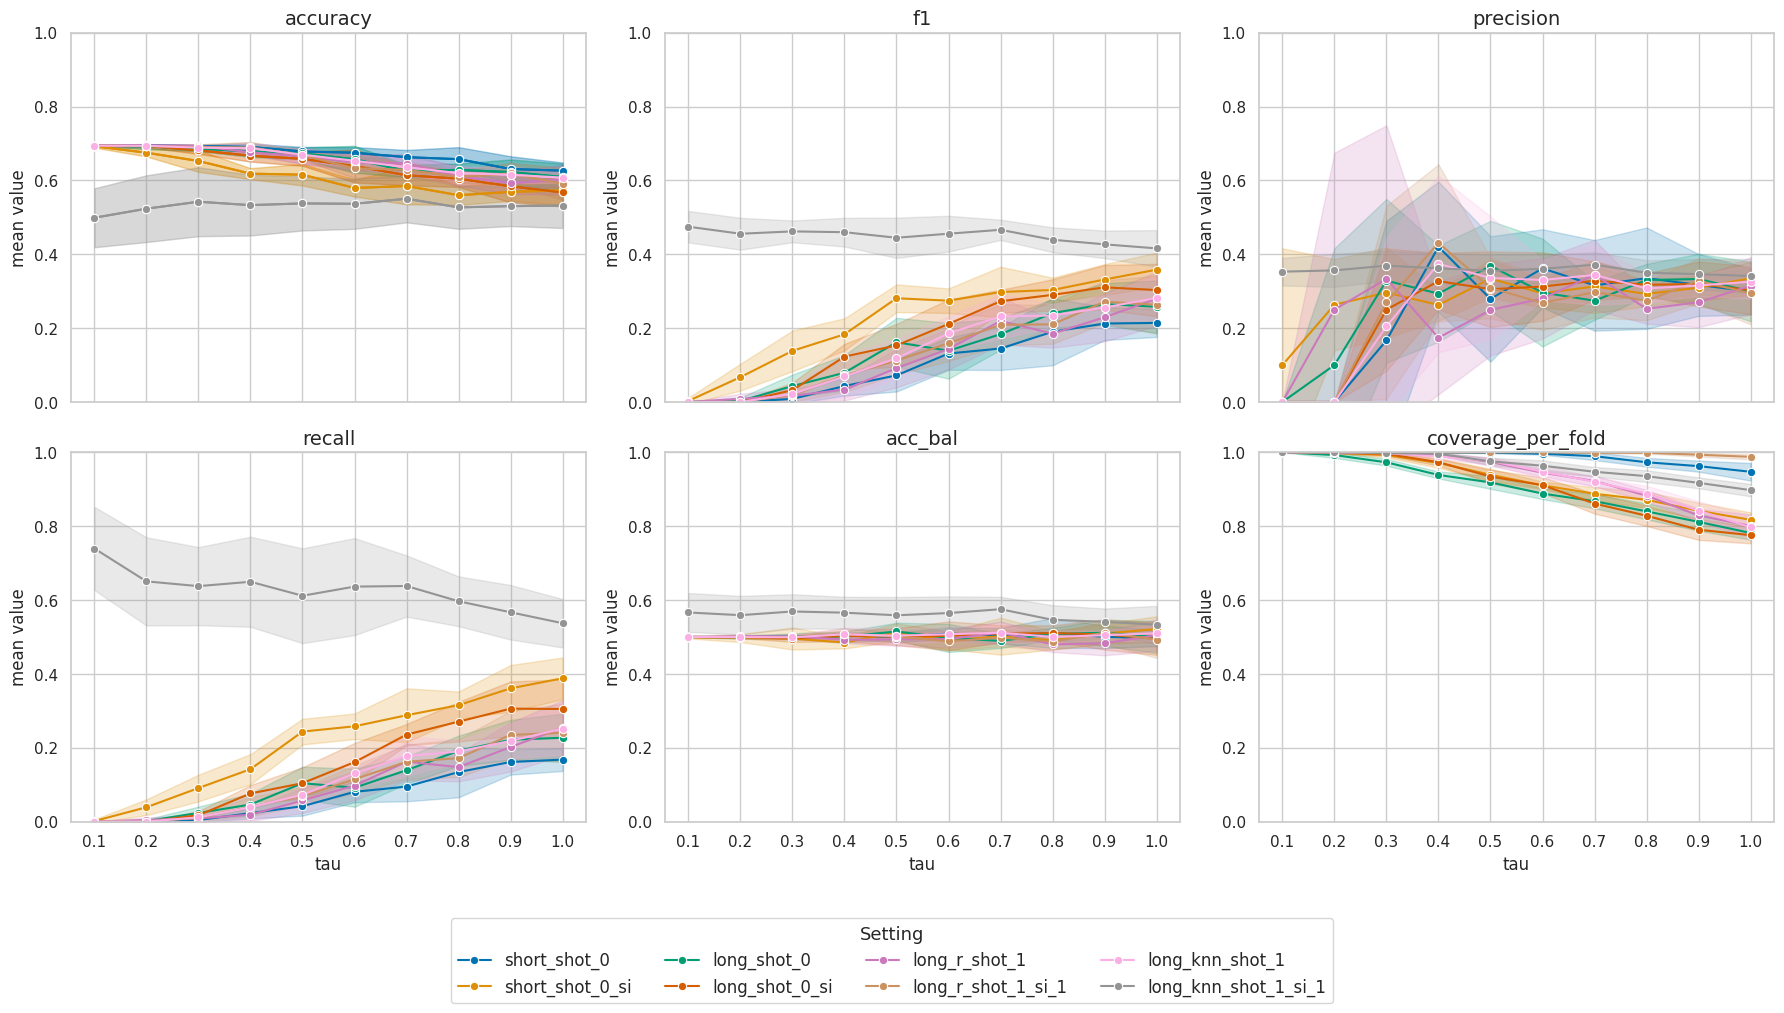

In [150]:
sns.set(style="whitegrid", palette="colorblind")

taus = np.sort(df_long_metrics['tau'].unique())
metrics = df_long_metrics['metric'].unique()

fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True)
axes = axes.flatten()

subset_first = df_long_metrics[df_long_metrics['metric'] == metrics[0]]
g = sns.lineplot(
    data=subset_first,
    x='tau',
    y='value',
    hue='setting',
    estimator='mean',
    errorbar='sd',
    marker='o',
    ax=axes[0],
)
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend_.remove()

for ax, metric in zip(axes, metrics):
    subset = df_long_metrics[df_long_metrics['metric'] == metric]
    sns.lineplot(
        data=subset,
        x='tau',
        y='value',
        hue='setting',
        estimator='mean',
        errorbar='sd',
        marker='o',
        ax=ax,
        legend=False
    )
    
    ax.set_title(metric, fontsize=14)
    ax.set_xlabel("tau", fontsize=12)
    ax.set_ylabel("mean value", fontsize=12)
    ax.set_xticks(taus)
    ax.set_xticklabels([f"{t:.1f}" for t in taus])
    ax.set_ylim(0, 1)

fig.legend(
    handles,
    labels,
    title="Setting",
    loc='lower center',
    ncol=min(4, len(labels)),
    bbox_to_anchor=(0.5, -0.02),
    fontsize=12,
    title_fontsize=13
)

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()